# FTDI Device Info

In [1]:
from pyftdi.ftdi import Ftdi

devices = Ftdi.list_devices()

if not devices:
    print("❌ No FTDI devices found.")
else:

    \
    for entry in devices:
        try:
            # entry can be (UsbDeviceDescriptor, interface) or similar
            if isinstance(entry, tuple):
                dev_desc = entry[0]
                interfaces = entry[1] if len(entry) > 1 else []
            else:
                dev_desc = entry
                interfaces = []

            # UsbDeviceDescriptor fields
            vendor = getattr(dev_desc, "vid", None)
            product = getattr(dev_desc, "pid", None)
            serial = getattr(dev_desc, "sn", None)
            description = getattr(dev_desc, "description", None)

            print("✅ FTDI Device Found:")
            print(f"   Vendor ID   : {vendor:04x}" if vendor else "   Vendor ID   : Unknown")
            print(f"   Product ID  : {product:04x}" if product else "   Product ID  : Unknown")
            print(f"   Serial No.  : {serial or 'Unknown'}")
            print(f"   Description : {description or 'Unknown'}")
            print(f"   Interfaces  : {interfaces}")
            print()

        except Exception as e:
            print(f"⚠️ Could not parse entry {entry}: {e}")


✅ FTDI Device Found:
   Vendor ID   : 0403
   Product ID  : 6014
   Serial No.  : ￿￿￿￿￿￿￿￿
   Description : ￿￿￿￿￿￿
   Interfaces  : 1



In [2]:
from pyftdi.ftdi import Ftdi

def safe_to_hex_string(value):
    """Return UTF-8 string if printable, else show hex representation."""
    if value is None:
        return 'None'
    try:
        if all(0x20 <= ord(c) <= 0x7E for c in value):
            return value  # printable ASCII
        else:
            raise UnicodeEncodeError
    except Exception:
        return ' '.join(f'{ord(c):02X}' for c in value)

devices = Ftdi.list_devices()

if not devices:
    print("❌ No FTDI devices found.")
else:
    for entry in devices:
        try:
            if isinstance(entry, tuple):
                dev_desc = entry[0]
                interfaces = entry[1] if len(entry) > 1 else []
            else:
                dev_desc = entry
                interfaces = []

            vendor = getattr(dev_desc, "vid", None)
            product = getattr(dev_desc, "pid", None)
            serial = getattr(dev_desc, "sn", None)
            description = getattr(dev_desc, "description", None)

            print("✅ FTDI Device Found:")
            print(f"   Vendor ID   : {vendor:04X}" if vendor else "   Vendor ID   : Unknown")
            print(f"   Product ID  : {product:04X}" if product else "   Product ID  : Unknown")
            print(f"   Serial No.  : 0x{safe_to_hex_string(serial)}")
            print(f"   Description : 0x{safe_to_hex_string(description)}")
            print(f"   Interfaces  : {interfaces}")
            print()

        except Exception as e:
            print(f"⚠️ Could not parse entry {entry}: {e}")


✅ FTDI Device Found:
   Vendor ID   : 0403
   Product ID  : 6014
   Serial No.  : 0xFFFF FFFF FFFF FFFF FFFF FFFF FFFF FFFF
   Description : 0xFFFF FFFF FFFF FFFF FFFF FFFF
   Interfaces  : 1



# FTDI FT232H Sanity Test

In [3]:
from pyftdi.ftdi import Ftdi
from pyftdi.i2c import I2cController
from IPython.display import display, Markdown
import traceback

'''
Bus Rate
-  100 kHz ... default
-  400 kHz
- 1000 kHz
'''

BUS_RATE = 4e5


display(Markdown("## 🔍 FT232H Sanity Test"))

try:
    display(Markdown("**🔹 Scanning for FTDI devices...**"))
    Ftdi.show_devices()
except Exception as e:
    display(Markdown(f"❌ **Could not list FTDI devices:** `{e}`"))
    traceback.print_exc()
else:
    try:
        display(Markdown("**🔹 Initializing I2C interface...**"))
        i2c = I2cController()
        i2c.configure('ftdi://ftdi:232h/1', frequency=BUS_RATE) 


        freq = i2c.frequency
        display(Markdown(f"✅ **Connected to FT232H via I2C** at **{freq/1000:.1f} kHz**"))

        # ✅ Manually scan I2C addresses 0x03–0x77
        display(Markdown("**🔹 Scanning I2C bus...**"))
        found = []
        for addr in range(0x03, 0x78):
            try:
                port = i2c.get_port(addr)
                port.read(1)  # Try reading one byte (safe test)
                found.append(addr)
            except Exception:
                # No device responded
                pass

        if found:
            md = "\n".join([f"- `0x{addr:02X}`" for addr in found])
            display(Markdown(f"✅ **Found I2C devices:**\n{md}"))
        else:
            display(Markdown("⚠️ **No I2C devices detected.** Check wiring or power."))

        i2c.terminate()
        display(Markdown("✅ **Test complete — FT232H is working properly.**"))

    except Exception as e:
        display(Markdown(f"❌ **Failed to communicate with FT232H:** `{e}`"))
        traceback.print_exc()


## 🔍 FT232H Sanity Test

**🔹 Scanning for FTDI devices...**

Available interfaces:
  ftdi://ftdi:232h:1/1  (￿￿￿￿￿￿)



**🔹 Initializing I2C interface...**

✅ **Connected to FT232H via I2C** at **400.0 kHz**

**🔹 Scanning I2C bus...**

✅ **Found I2C devices:**
- `0x68`

✅ **Test complete — FT232H is working properly.**

# MPU6050

In [4]:
from pyftdi.i2c import I2cController
import struct, time, sys

# --- MPU-6050 constants ---
MPU_ADDR      = 0x68
PWR_MGMT_1    = 0x6B
ACCEL_XOUT_H  = 0x3B

BUS_RATE = 4e5

# --- Initialize I2C via FT232H ---
i2c = I2cController()
i2c.configure('ftdi://ftdi:232h/1?frequency={}'.format(BUS_RATE))  
mpu = i2c.get_port(MPU_ADDR)

# --- Wake up sensor ---
mpu.write_to(PWR_MGMT_1, b'\x00')
time.sleep(0.1)

# --- Read and convert raw data ---
def read_mpu6050():
    raw = mpu.exchange([ACCEL_XOUT_H], 14)
    ax, ay, az, temp, gx, gy, gz = struct.unpack('>hhhhhhh', raw)
    return {
        'ax': ax / 16384.0,  # g
        'ay': ay / 16384.0,
        'az': az / 16384.0,
        'gx': gx / 131.0,    # °/s
        'gy': gy / 131.0,
        'gz': gz / 131.0,
        'temp': temp / 340.0 + 36.53
    }

# --- Continuous read loop ---
print("Streaming MPU6050 data... (Ctrl+C to stop)\n")
try:
    while True:
        d = read_mpu6050()
        line = (f"A=({d['ax']:+.2f}, {d['ay']:+.2f}, {d['az']:+.2f}) g   "
                f"G=({d['gx']:+6.1f}, {d['gy']:+6.1f}, {d['gz']:+6.1f}) °/s   "
                f"T={d['temp']:.2f} °C\r")
        sys.stdout.write(line)
        sys.stdout.flush()
        time.sleep(0.05)  # ~20 Hz refresh
except KeyboardInterrupt:
    print("\nStopped by user.")
finally:
    i2c.terminate()


Streaming MPU6050 data... (Ctrl+C to stop)

A=(+0.05, -0.02, +0.80) g   G=(  -1.5,   +0.5,   +1.4) °/s   T=21.89 °C
Stopped by user.


# Capture Class

In [216]:
from pyftdi.i2c import I2cController
import struct, time, sys
from typing import List, Dict, Optional

class MPU6050:
    # --- I2C address ---
    DEFAULT_ADDR = 0x68

    # --- Registers ---
    REG_SMPLRT_DIV   = 0x19
    REG_CONFIG       = 0x1A
    REG_GYRO_CONFIG  = 0x1B
    REG_ACCEL_CONFIG = 0x1C
    REG_FIFO_EN      = 0x23
    REG_INT_ENABLE   = 0x38
    REG_INT_STATUS   = 0x3A
    REG_TEMP_OUT_H   = 0x41
    REG_TEMP_OUT_L   = 0x42
    REG_USER_CTRL    = 0x6A
    REG_PWR_MGMT_1   = 0x6B
    REG_PWR_MGMT_2   = 0x6C
    REG_FIFO_COUNTH  = 0x72
    REG_FIFO_COUNTL  = 0x73
    REG_FIFO_R_W     = 0x74
    REG_WHO_AM_I     = 0x75

    # --- Scales (±2 g, ±250 °/s) ---
    ACCEL_SCALE = 16384.0
    GYRO_SCALE  = 131.0

    def __init__(
        self,
        url: str = "ftdi://ftdi:232h/1",
        bus_rate: int = 400_000,
        addr: int = DEFAULT_ADDR,
        sample_div: int = 4,      # 1kHz/(1+div) => 200 Hz
        dlpf_cfg: int = 0x03,     # 42 Hz
        accel_cfg: int = 0x00,    # ±2 g
        gyro_cfg: int = 0x00,     # ±250 dps
        verbose: bool = True,
        check_id: bool = True,
    ):
        self.verbose = verbose
        self.addr = addr

        # --- I2C setup ---
        self.i2c = I2cController()
        self.i2c.configure(f"{url}?frequency={bus_rate}")
        self.mpu = self.i2c.get_port(self.addr)

        if self.verbose:
            print(f"🧩 Connected via {url} @ {bus_rate} Hz, addr=0x{self.addr:02X}")

        # Optional identity check
        if check_id:
            who = self._read8(self.REG_WHO_AM_I)
            print(f"🆔 WHO_AM_I = 0x{who:02X}")
            if who != 0x68 and self.verbose:
                print("⚠️ Unexpected WHO_AM_I (check AD0/wiring)")

        # Init
        self._soft_init(sample_div, dlpf_cfg, accel_cfg, gyro_cfg)
        if self.verbose:
            self.dump_regs()

    # --------- Low-level I²C helpers ---------
    def _write8(self, reg: int, val: int) -> None:
        self.mpu.write_to(reg, bytes([val & 0xFF]))
        time.sleep(0.002)

    def _read8(self, reg: int) -> int:
        return self.mpu.exchange([reg], 1)[0]

    def _read16_be(self, reg: int) -> int:
        return struct.unpack('>H', self.mpu.exchange([reg], 2))[0]

    def _fifo_read(self, nbytes: int) -> bytes:
        return self.mpu.exchange([self.REG_FIFO_R_W], nbytes)

    def _fifo_reset(self) -> None:
        self._write8(self.REG_USER_CTRL, self._read8(self.REG_USER_CTRL) | 0x04)
        time.sleep(0.01)
        self._write8(self.REG_USER_CTRL, self._read8(self.REG_USER_CTRL) & ~0x04)
        time.sleep(0.01)

    # --------- Temperature ---------
    def read_temperature(self) -> float:
        """Read temperature once (°C) using datasheet formula."""
        h = self._read8(self.REG_TEMP_OUT_H)
        l = self._read8(self.REG_TEMP_OUT_L)
        raw = (h << 8) | l
        if raw >= 0x8000:
            raw -= 0x10000
        return raw / 340.0 + 36.53

    # --------- Init / control ---------
    def _soft_init(self, sample_div: int, dlpf_cfg: int, accel_cfg: int, gyro_cfg: int) -> None:
        # No hard reset (clones may NACK after 0x80)
        self._write8(self.REG_PWR_MGMT_1, 0x01)  # PLL X-gyro
        self._write8(self.REG_PWR_MGMT_2, 0x00)  # all sensors on
        time.sleep(0.05)

        # Basic config
        self._write8(self.REG_CONFIG, dlpf_cfg & 0x07)
        self._write8(self.REG_SMPLRT_DIV, sample_div & 0xFF)
        self._write8(self.REG_GYRO_CONFIG, gyro_cfg & 0x18)   # FS bits [4:3]
        self._write8(self.REG_ACCEL_CONFIG, accel_cfg & 0x18) # FS bits [4:3]

        # FIFO off, reset
        self._write8(self.REG_USER_CTRL, 0x00)
        self._write8(self.REG_FIFO_EN, 0x00)
        self._fifo_reset()
        time.sleep(0.05)

        # Enable FIFO logic + select accel+gyro
        self._write8(self.REG_USER_CTRL, 0x40)   # FIFO_EN (logic)
        self._write8(self.REG_FIFO_EN, 0x78)     # XG|YG|ZG|ACCEL
        self._write8(self.REG_INT_ENABLE, 0x01)  # data-ready (optional)
        _ = self._read8(self.REG_INT_STATUS)     # clear stale interrupt

        # Quick FIFO growth sanity
        if self.verbose:
            for t in (0.05, 0.10, 0.20):
                time.sleep(t)
                cnt = self._read16_be(self.REG_FIFO_COUNTH)
                print(f"FIFO count @ +{int(t*1000)} ms: {cnt}")

    def dump_regs(self) -> None:
        regs = [
            ("WHO_AM_I",     self.REG_WHO_AM_I),
            ("PWR_MGMT_1",   self.REG_PWR_MGMT_1),
            ("PWR_MGMT_2",   self.REG_PWR_MGMT_2),
            ("CONFIG",       self.REG_CONFIG),
            ("SMPLRT_DIV",   self.REG_SMPLRT_DIV),
            ("GYRO_CONFIG",  self.REG_GYRO_CONFIG),
            ("ACCEL_CONFIG", self.REG_ACCEL_CONFIG),
            ("USER_CTRL",    self.REG_USER_CTRL),
            ("FIFO_EN",      self.REG_FIFO_EN),
            ("INT_ENABLE",   self.REG_INT_ENABLE),
            ("INT_STATUS",   self.REG_INT_STATUS),
        ]
        print("\n🔎 Register dump:")
        for name, r in regs:
            print(f"   {name:<14}= 0x{self._read8(r):02X}")
        print()

    # --------- Capture API ---------
    def capture(
        self,
        duration_s: Optional[float] = 5.0,
        max_samples: Optional[int] = None,
        print_rate_hz: float = 10.0,
        return_raw: bool = False,
        include_temp: bool = True,
    ) -> List[Dict[str, float]]:
        """
        Capture accel/gyro samples via FIFO, with optional temperature per batch.

        duration_s: stop after this many seconds (None to ignore)
        max_samples: stop after this many samples (None to ignore)
        print_rate_hz: terminal update rate (0 disables prints)
        return_raw: return raw ints instead of scaled floats
        include_temp: read temperature once per FIFO drain and add to each record

        Returns list of dicts: {t, ax, ay, az, gx, gy, gz, temp?}
        """
        if duration_s is None and max_samples is None:
            duration_s = 5.0

        data_log: List[Dict[str, float]] = []
        if self.verbose:
            print("📡 Capturing FIFO data... (Ctrl+C to stop)\n")

        t0 = time.time()
        last_print = 0.0
        bytes_per_sample = 12  # 6 accel + 6 gyro

        try:
            while True:
                if duration_s is not None and (time.time() - t0) >= duration_s:
                    break
                if max_samples is not None and len(data_log) >= max_samples:
                    break

                fifo_count = self._read16_be(self.REG_FIFO_COUNTH)

                if fifo_count > 1020:
                    self._fifo_reset()
                    continue

                if fifo_count < bytes_per_sample:
                    time.sleep(0.003)
                    continue

                # Read temperature once per batch if requested
                temp_c = self.read_temperature() if include_temp else None

                to_read = (fifo_count // bytes_per_sample) * bytes_per_sample
                blob = self._fifo_read(to_read)

                for i in range(0, len(blob), bytes_per_sample):
                    ax, ay, az, gx, gy, gz = struct.unpack('>hhhhhh', blob[i:i+bytes_per_sample])

                    rec_t = time.time()
                    if return_raw:
                        rec = {'t': rec_t, 'ax': ax, 'ay': ay, 'az': az, 'gx': gx, 'gy': gy, 'gz': gz}
                    else:
                        rec = {
                            't': rec_t,
                            'ax': ax/self.ACCEL_SCALE, 'ay': ay/self.ACCEL_SCALE, 'az': az/self.ACCEL_SCALE,
                            'gx': gx/self.GYRO_SCALE,  'gy': gy/self.GYRO_SCALE,  'gz': gz/self.GYRO_SCALE
                        }
                    if include_temp:
                        rec['temp'] = temp_c
                    data_log.append(rec)

                # Throttled console status
                if print_rate_hz and print_rate_hz > 0:
                    now = time.time()
                    if (now - last_print) >= (1.0 / print_rate_hz):
                        last_print = now
                        rec = data_log[-1]
                        if return_raw:
                            sys.stdout.write(
                                f"\rA=({rec['ax']:+6d},{rec['ay']:+6d},{rec['az']:+6d})  "
                                f"G=({rec['gx']:+6d},{rec['gy']:+6d},{rec['gz']:+6d})  "
                                + (f"T={rec['temp']:.2f}°C  " if include_temp else "")
                                + f"n_samples={len(data_log)}     "
                            )
                        else:
                            sys.stdout.write(
                                f"\rA=({rec['ax']:+.2f},{rec['ay']:+.2f},{rec['az']:+.2f}) g  "
                                f"G=({rec['gx']:+6.1f},{rec['gy']:+6.1f},{rec['gz']:+6.1f}) °/s  "
                                + (f"T={rec['temp']:.2f}°C  " if include_temp else "")
                                + f"n_samples={len(data_log)}     "
                            )
                        sys.stdout.flush()

        except KeyboardInterrupt:
            print("\n🛑 Stopped by user.")
        finally:
            if self.verbose:
                print(f"\n📦 Recorded {len(data_log)} samples.")
            return data_log

    # --------- Cleanup / context manager ---------
    def close(self) -> None:
        try:
            self._write8(self.REG_FIFO_EN, 0x00)
            self._write8(self.REG_USER_CTRL, self._read8(self.REG_USER_CTRL) & ~0x40)
        except Exception:
            pass
        self.i2c.terminate()
        if self.verbose:
            print("🔚 FIFO disabled, I²C connection closed.")

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc, tb):
        self.close()





In [6]:
# --------- Example usage ---------
if __name__ == "__main__":
    try:
        with MPU6050(
            url="ftdi://ftdi:232h/1",
            bus_rate=400_000,
            sample_div=4,     # 200 Hz
            dlpf_cfg=3,       # 42 Hz
            accel_cfg=0x00,   # ±2 g
            gyro_cfg=0x00,    # ±250 dps
            verbose=True
        ) as imu:
            # e.g., capture for 3 seconds, show live prints, include temperature
            samples = imu.capture(duration_s=3.0, max_samples=None, print_rate_hz=20.0, include_temp=True)

            # samples is a list of dicts:
            # [{'t': ..., 'ax': ..., 'ay': ..., 'az': ..., 'gx': ..., 'gy': ..., 'gz': ..., 'temp': ...}, ...]
    except Exception as e:
        print(f"❌ Error: {e}")

🧩 Connected via ftdi://ftdi:232h/1 @ 400000 Hz, addr=0x68
🆔 WHO_AM_I = 0x68
FIFO count @ +50 ms: 300
FIFO count @ +100 ms: 636
FIFO count @ +200 ms: 1024

🔎 Register dump:
   WHO_AM_I      = 0x68
   PWR_MGMT_1    = 0x01
   PWR_MGMT_2    = 0x00
   CONFIG        = 0x03
   SMPLRT_DIV    = 0x04
   GYRO_CONFIG   = 0x00
   ACCEL_CONFIG  = 0x00
   USER_CTRL     = 0x40
   FIFO_EN       = 0x78
   INT_ENABLE    = 0x01
   INT_STATUS    = 0x11

📡 Capturing FIFO data... (Ctrl+C to stop)

A=(+0.03,+0.00,+0.79) g  G=(  -1.4,  +0.5,  +1.5) °/s  T=22.44°C  n_samples=579     
📦 Recorded 579 samples.
🔚 FIFO disabled, I²C connection closed.


In [527]:
imu = MPU6050(
            url="ftdi://ftdi:232h/1",
            bus_rate=400_000,
            sample_div=4,     # 200 Hz
            dlpf_cfg=3,       # 42 Hz
            accel_cfg=0x00,   # ±2 g
            gyro_cfg=0x00,    # ±250 dps
            verbose=True
        )

🧩 Connected via ftdi://ftdi:232h/1 @ 400000 Hz, addr=0x68
🆔 WHO_AM_I = 0x68
FIFO count @ +50 ms: 312
FIFO count @ +100 ms: 636
FIFO count @ +200 ms: 1024

🔎 Register dump:
   WHO_AM_I      = 0x68
   PWR_MGMT_1    = 0x01
   PWR_MGMT_2    = 0x00
   CONFIG        = 0x03
   SMPLRT_DIV    = 0x04
   GYRO_CONFIG   = 0x00
   ACCEL_CONFIG  = 0x00
   USER_CTRL     = 0x40
   FIFO_EN       = 0x78
   INT_ENABLE    = 0x01
   INT_STATUS    = 0x11



In [528]:
samples = imu.capture(duration_s=300.0, max_samples=1e5, print_rate_hz=20.0)

📡 Capturing FIFO data... (Ctrl+C to stop)

A=(+0.03,+0.00,+0.78) g  G=(  -1.4,  +0.6,  +1.4) °/s  T=24.97°C  n_samples=5201     
🛑 Stopped by user.

📦 Recorded 5201 samples.


In [529]:
imu.close()

🔚 FIFO disabled, I²C connection closed.


In [220]:
samples[:2]

[{'t': 1762526852.1500993,
  'ax': 0.0333251953125,
  'ay': 0.0003662109375,
  'az': 0.778564453125,
  'gx': -1.4274809160305344,
  'gy': 0.6793893129770993,
  'gz': 1.4274809160305344,
  'temp': 25.73},
 {'t': 1762526852.1501255,
  'ax': 0.031005859375,
  'ay': 0.0013427734375,
  'az': 0.7691650390625,
  'gx': -1.4351145038167938,
  'gy': 0.6870229007633588,
  'gz': 1.3893129770992367,
  'temp': 25.73}]

# Plot Data

📊 Recorded 22917 samples over 114.437 s
⚙️ Expected sample rate: 200.0 Hz → Δt = 5.00 ms
🧠 Inferred actual rate: 200.2 Hz → Δt = 4.99 ms


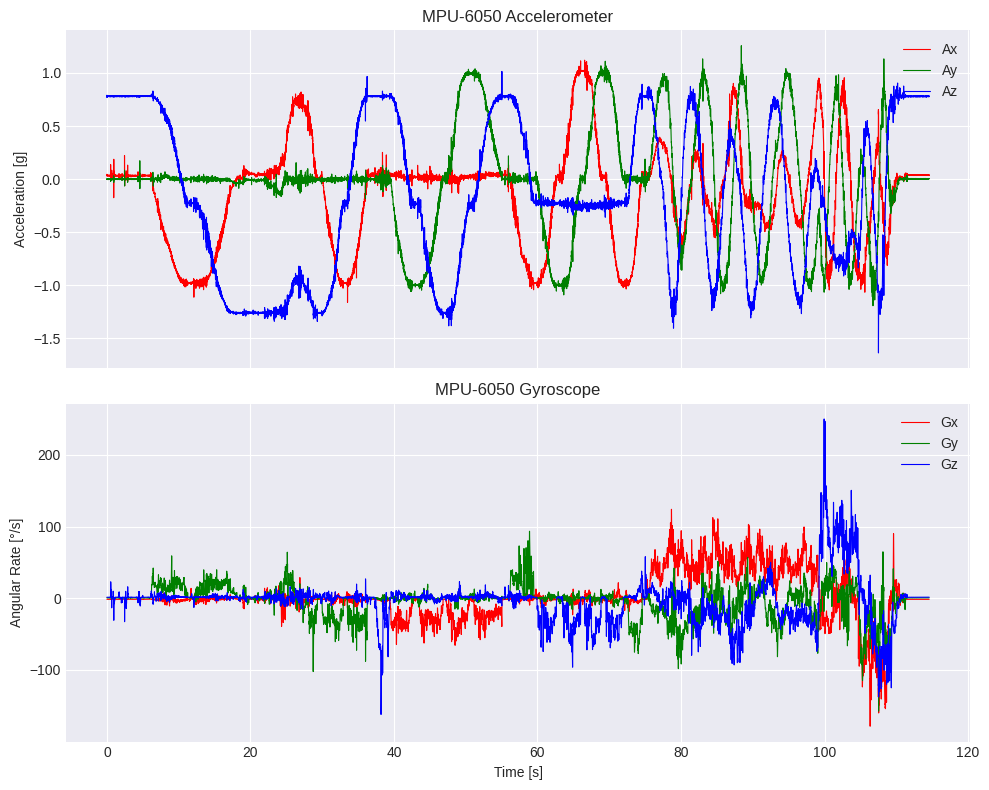

In [221]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mpu6050_dictlog(data_log, sample_rate_hz=200):
    """
    Plot MPU-6050 data when each sample is a dict:
    {'t': ..., 'ax': ..., 'ay': ..., 'az': ..., 'gx': ..., 'gy': ..., 'gz': ...}
    
    Arguments
    ----------
    data_log : list of dicts
        Recorded data points.
    sample_rate_hz : float
        Expected sample rate from the sensor configuration (Hz).
    """
    if not data_log:
        print("⚠️ data_log is empty — nothing to plot.")
        return

    n = len(data_log)

    # Extract recorded timestamps (real host-side times)
    host_t = np.array([d["t"] for d in data_log])
    total_time = host_t[-1] - host_t[0]
    actual_rate = (n - 1) / total_time if total_time > 0 else 0.0
    expected_rate = sample_rate_hz

    print(f"📊 Recorded {n} samples over {total_time:.3f} s")
    print(f"⚙️ Expected sample rate: {expected_rate:.1f} Hz → Δt = {1/expected_rate*1000:.2f} ms")
    print(f"🧠 Inferred actual rate: {actual_rate:.1f} Hz → Δt = {1/actual_rate*1000:.2f} ms")

    # Warn if difference >10%
    if abs(actual_rate - expected_rate) / expected_rate > 0.1:
        print("⚠️ WARNING: inferred rate differs from expected by >10% (host read delay or mis-set SMPLRT_DIV)")

    # Use synthetic uniform time base (true sample spacing)
    dt = 1.0 / expected_rate
    t = np.arange(n) * dt

    # Extract arrays
    ax = np.array([d["ax"] for d in data_log])
    ay = np.array([d["ay"] for d in data_log])
    az = np.array([d["az"] for d in data_log])
    gx = np.array([d["gx"] for d in data_log])
    gy = np.array([d["gy"] for d in data_log])
    gz = np.array([d["gz"] for d in data_log])

    plt.style.use("seaborn-v0_8-darkgrid")
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # --- Accelerometer ---
    axs[0].plot(t, ax, "r-", lw=0.8, label="Ax")
    axs[0].plot(t, ay, "g-", lw=0.8, label="Ay")
    axs[0].plot(t, az, "b-", lw=0.8, label="Az")
    axs[0].set_ylabel("Acceleration [g]")
    axs[0].set_title("MPU-6050 Accelerometer")
    axs[0].legend(loc="upper right")

    # --- Gyroscope ---
    axs[1].plot(t, gx, "r-", lw=0.8, label="Gx")
    axs[1].plot(t, gy, "g-", lw=0.8, label="Gy")
    axs[1].plot(t, gz, "b-", lw=0.8, label="Gz")
    axs[1].set_ylabel("Angular Rate [°/s]")
    axs[1].set_xlabel("Time [s]")
    axs[1].set_title("MPU-6050 Gyroscope")
    axs[1].legend(loc="upper right")

    plt.tight_layout()
    plt.show()

plot_mpu6050_dictlog(samples)

In [222]:
import pandas as pd
df = pd.DataFrame(samples)
df

t        ax        ay        az        gx        gy  \
0      1.762527e+09  0.033325  0.000366  0.778564 -1.427481  0.679389   
1      1.762527e+09  0.031006  0.001343  0.769165 -1.435115  0.687023   
2      1.762527e+09  0.042480 -0.003906  0.790161 -1.488550  0.633588   
3      1.762527e+09  0.045166 -0.001099  0.772217 -1.488550  0.656489   
4      1.762527e+09  0.031738  0.001953  0.779175 -1.404580  0.709924   
...             ...       ...       ...       ...       ...       ...   
22912  1.762527e+09  0.035645  0.002930  0.783447 -1.534351  0.549618   
22913  1.762527e+09  0.037842  0.004883  0.782104 -1.488550  0.580153   
22914  1.762527e+09  0.036011  0.003174  0.778076 -1.488550  0.603053   
22915  1.762527e+09  0.036865  0.002930  0.779175 -1.526718  0.603053   
22916  1.762527e+09  0.035889  0.002563  0.776123 -1.503817  0.572519   

             gz       temp  
0      1.427481  25.730000  
1      1.389313  25.730000  
2      1.374046  25.730000  
3      1.389313  25.730000  
4      1.442748  25.730000  
...         ...        ...  
22912  1.412214  26.394706  
22913  1.442748  26.394706  
22914  1.442748  26.394706  
22915  1.473282  26.394706  
22916  1.473282  26.394706  

[22917 rows x 8 columns]

In [223]:
import numpy as np
import pandas as pd

def analyze_mpu6050_stats(data_log, as_dataframe=True, verbose=True):
    """
    Compute descriptive statistics for each signal in a recorded MPU6050 data_log.

    Each entry in data_log must be a dict:
        {'t': ..., 'ax': ..., 'ay': ..., 'az': ..., 'gx': ..., 'gy': ..., 'gz': ...}

    Returns:
        - A dict or pandas.DataFrame with summary stats for each signal.
    """
    if not data_log:
        print("⚠️ data_log is empty — nothing to analyze.")
        return None

    # Extract signals as arrays
    signals = {k: np.array([d[k] for d in data_log]) for k in data_log[0].keys() if k != 't'}

    stats = {}
    for name, arr in signals.items():
        mean = np.mean(arr)
        std = np.std(arr)
        minv = np.min(arr)
        maxv = np.max(arr)
        rms = np.sqrt(np.mean(arr**2))
        peak_to_peak = maxv - minv
        median = np.median(arr)
        mad = np.mean(np.abs(arr - mean))  # mean absolute deviation
        stats[name] = {
            "mean": mean,
            "std": std,
            "min": minv,
            "max": maxv,
            "peak_to_peak": peak_to_peak,
            "median": median,
            "mad": mad,
            "rms": rms,
        }

    # --- Optional: time base sanity ---
    t = np.array([d["t"] for d in data_log])
    duration = t[-1] - t[0]
    rate = len(t) / duration if duration > 0 else 0
    stats["meta"] = {"samples": len(t), "duration_s": duration, "rate_est_Hz": rate}

    if as_dataframe:
        df = pd.DataFrame(stats).T  # transpose for nice row-per-signal format
        if verbose:
            print("📊 MPU-6050 Signal Statistics:\n")
            print(df.round(6))
        return df
    else:
        if verbose:
            print(stats)
        return stats

analyze_mpu6050_stats(samples)

📊 MPU-6050 Signal Statistics:

           mean        std         min         max  peak_to_peak     median  \
ax    -0.128727   0.468771   -1.161743    1.120239      2.281982   0.010498   
ay    -0.014247   0.506356   -1.193848    1.256958      2.450806  -0.002197   
az    -0.173169   0.720280   -1.638794    1.014526      2.653320  -0.225952   
gx     2.727995  32.381183 -178.549618  124.114504    302.664122  -1.442748   
gy    -4.283844  21.599923 -157.450382   93.503817    250.954198   0.450382   
gz    -4.127047  30.939826 -162.129771  250.129771    412.259542   1.282443   
temp  26.032533   0.240163   25.235882   26.738824      1.502941  26.000588   
meta        NaN        NaN         NaN         NaN           NaN        NaN   

            mad        rms  samples  duration_s  rate_est_Hz  
ax     0.365429   0.486124      NaN         NaN          NaN  
ay     0.335392   0.506556      NaN         NaN          NaN  
az     0.614236   0.740804      NaN         NaN          NaN  
gx   

mean        std         min         max  peak_to_peak     median  \
ax    -0.128727   0.468771   -1.161743    1.120239      2.281982   0.010498   
ay    -0.014247   0.506356   -1.193848    1.256958      2.450806  -0.002197   
az    -0.173169   0.720280   -1.638794    1.014526      2.653320  -0.225952   
gx     2.727995  32.381183 -178.549618  124.114504    302.664122  -1.442748   
gy    -4.283844  21.599923 -157.450382   93.503817    250.954198   0.450382   
gz    -4.127047  30.939826 -162.129771  250.129771    412.259542   1.282443   
temp  26.032533   0.240163   25.235882   26.738824      1.502941  26.000588   
meta        NaN        NaN         NaN         NaN           NaN        NaN   

            mad        rms  samples  duration_s  rate_est_Hz  
ax     0.365429   0.486124      NaN         NaN          NaN  
ay     0.335392   0.506556      NaN         NaN          NaN  
az     0.614236   0.740804      NaN         NaN          NaN  
gx    20.533742  32.495892      NaN         NaN          NaN  
gy    15.008531  22.020627      NaN         NaN          NaN  
gz    18.136567  31.213864      NaN         NaN          NaN  
temp   0.208826  26.033641      NaN         NaN          NaN  
meta        NaN        NaN  22917.0  114.437005    200.25865

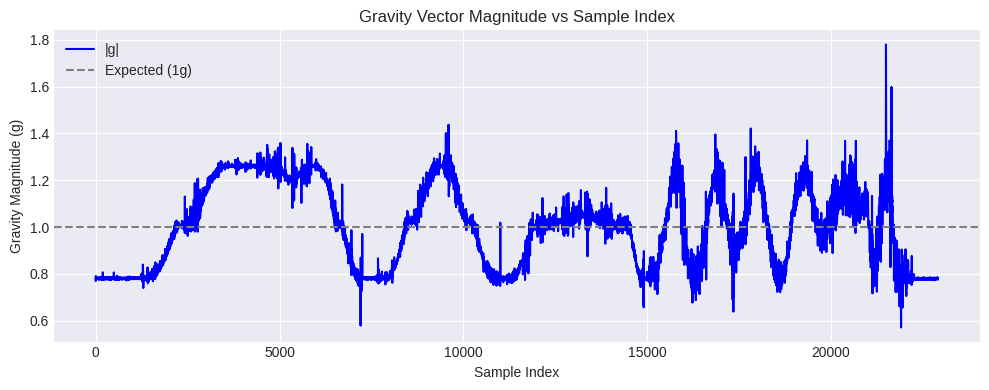

In [224]:
import numpy as np
import matplotlib.pyplot as plt

def plot_gravity_magnitude(data_log):
    """
    Plots the magnitude of the gravity vector ||g|| = sqrt(ax^2 + ay^2 + az^2)
    using sample index on the x-axis.
    """
    # Extract acceleration values
    ax_vals = np.array([d['ax'] for d in data_log])
    ay_vals = np.array([d['ay'] for d in data_log])
    az_vals = np.array([d['az'] for d in data_log])

    # Compute magnitude of the gravity vector
    g_mag = np.sqrt(ax_vals**2 + ay_vals**2 + az_vals**2)

    # X-axis: sample index
    indices = np.arange(len(g_mag))

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(indices, g_mag, label='|g|', color='blue')
    plt.axhline(1.0, color='gray', linestyle='--', label='Expected (1g)')
    plt.xlabel("Sample Index")
    plt.ylabel("Gravity Magnitude (g)")
    plt.title("Gravity Vector Magnitude vs Sample Index")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_gravity_magnitude(samples)

# Plot 3D Data and Projections

In [225]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_accel_3d_with_projections(data_log):
    """
    Plots 3D acceleration values (ax, ay, az) as dots,
    along with 2D projections on the XY, XZ, and YZ planes.
    All subplots are the same size and aspect ratio is fixed to 1:1.
    """

    val = 1.5
    axis_lim = [-val, val]

    # Extract acceleration data
    ax_vals = [d['ax'] for d in data_log]
    ay_vals = [d['ay'] for d in data_log]
    az_vals = [d['az'] for d in data_log]

    # Create figure with 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs = axs.flatten()  # Flatten to 1D list for indexed access

    # --- 3D Scatter plot (axs[0]) ---
    ax3d = fig.add_subplot(2, 2, 1, projection='3d')
    ax3d.scatter(ax_vals, ay_vals, az_vals, c='blue', s=20, alpha=0.7)
    ax3d.set_title('3D Acceleration Scatter')
    ax3d.set_xlabel('ax (g)')
    ax3d.set_ylabel('ay (g)')
    ax3d.set_zlabel('az (g)')

    # Set fixed 3D axis limits (optional: symmetrical around 0 or auto-computed)
    ax3d.set_xlim(axis_lim)
    ax3d.set_ylim(axis_lim)
    ax3d.set_zlim(axis_lim)

    # --- 2D Projection: XY (axs[1]) ---
    axs[1].scatter(ax_vals, ay_vals, c='darkgreen', s=20, alpha=0.7)
    axs[1].set_title('XY Projection')
    axs[1].set_xlabel('ax (g)')
    axs[1].set_ylabel('ay (g)')
    axs[1].grid(True)
    axs[1].set_aspect('equal', adjustable='box')
    axs[1].set_xlim(axis_lim)
    axs[1].set_ylim(axis_lim)

    # --- 2D Projection: XZ (axs[2]) ---
    axs[2].scatter(ax_vals, az_vals, c='purple', s=20, alpha=0.7)
    axs[2].set_title('XZ Projection')
    axs[2].set_xlabel('ax (g)')
    axs[2].set_ylabel('az (g)')
    axs[2].grid(True)
    axs[2].set_aspect('equal', adjustable='box')
    axs[2].set_xlim(axis_lim)
    axs[2].set_ylim(axis_lim)

    # --- 2D Projection: YZ (axs[3]) ---
    axs[3].scatter(ay_vals, az_vals, c='orange', s=20, alpha=0.7)
    axs[3].set_title('YZ Projection')
    axs[3].set_xlabel('ay (g)')
    axs[3].set_ylabel('az (g)')
    axs[3].grid(True)
    axs[3].set_aspect('equal', adjustable='box')
    axs[3].set_xlim(axis_lim)
    axs[3].set_ylim(axis_lim)

    plt.tight_layout()
    plt.show()

plot_accel_3d_with_projections(samples)

# Fit Ellipsoid to Sampled Data

In [226]:
import numpy as np

def fit_ellipsoid_constrained(data):
    """
    Fits an ellipsoid to 3D points using an algebraic (constrained) fit,
    then converts the quadric to geometric parameters.

    Returns:
        center: (3,) ellipsoid center
        radii:  (3,) semi-axis lengths (a, b, c), sorted descending
        rotation: (3,3) rotation matrix whose columns are principal axes
    """
    data = np.asarray(data)
    x = data[:, 0][:, None]
    y = data[:, 1][:, None]
    z = data[:, 2][:, None]

    # Design matrix for the general quadric:
    # v = [Axx, Ayy, Azz, Axy, Axz, Ayz, Bx, By, Bz, C]^T
    D = np.hstack([x*x, y*y, z*z, x*y, x*z, y*z, x, y, z, np.ones_like(x)])

    # Algebraic fit: solve D v = 0 with ||v||=1 via SVD (last right-singular vector)
    _, _, vh = np.linalg.svd(D, full_matrices=False)
    v = vh.T[:, -1]

    # Unpack to symmetric form x^T Q x + u^T x + f = 0
    Q = np.array([
        [v[0],   v[3]/2, v[4]/2],
        [v[3]/2, v[1],   v[5]/2],
        [v[4]/2, v[5]/2, v[2]]
    ])
    u = np.array([v[6], v[7], v[8]])
    f = v[9]

    # Ensure Q is invertible
    if np.linalg.matrix_rank(Q) < 3:
        raise ValueError("Fitted quadric is degenerate (Q is not full rank).")

    # Center c = -1/2 Q^{-1} u
    center = -0.5 * np.linalg.solve(Q, u)

    # Scale term k = c^T Q c - f
    k = center @ Q @ center - f

    # If k <= 0 or Q not positive definite, flip global sign
    # (The algebraic solution is up to a scalar factor.)
    eigvals = np.linalg.eigvalsh(Q)
    if k <= 0 or np.any(eigvals <= 0):
        Q = -Q
        u = -u
        f = -f
        center = -0.5 * np.linalg.solve(Q, u)
        k = center @ Q @ center - f
        eigvals = np.linalg.eigvalsh(Q)

    if k <= 0 or np.any(eigvals <= 0):
        raise ValueError("Fitted surface is not an ellipsoid (k<=0 or Q not PD).")

    # Diagonalize Q for axes and rotation
    evals, evecs = np.linalg.eigh(Q)  # Q = evecs @ diag(evals) @ evecs.T
    # Radii from (x')^T diag(evals) (x') = k  ->  x' = evecs^T (x - center)
    radii = np.sqrt(k / evals)

    # Sort axes from largest to smallest for consistency
    order = np.argsort(radii)[::-1]
    radii = radii[order]
    rotation = evecs[:, order]

    return center, radii, rotation


In [227]:
data = np.array([[d['ax'], d['ay'], d['az']] for d in samples])
center, radii, rotation = fit_ellipsoid_constrained(data)

print("Center:", center)
print("Radii:", radii)
print("Rotation matrix:\n", rotation)


Center: [ 0.01862597 -0.0030247  -0.24107018]
Radii: [1.02304245 1.00206999 0.99653933]
Rotation matrix:
 [[-0.01293363 -0.58753444 -0.80909579]
 [-0.14338495  0.80189073 -0.58001035]
 [ 0.98958248  0.10851052 -0.09461495]]


### **Ellipsoid is close to a sphere => principal directions are ill-conditioned!**

In [228]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_ellipsoid(center, radii, rotation, raw_data=None, color='cyan', alpha=0.2):
    """
    Plots a 3D ellipsoid with given center, radii, and orientation.
    Optionally overlays raw 3D points.
    """
    # Create a sphere
    u = np.linspace(0, 2 * np.pi, 50)
    v = np.linspace(0, np.pi, 50)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))

    # Stack and reshape
    sphere = np.stack((x, y, z), axis=-1)  # shape (50, 50, 3)

    # Scale by radii
    ellipsoid = sphere @ np.diag(radii)

    # Rotate
    ellipsoid = ellipsoid @ rotation.T

    # Translate to center
    ellipsoid += center

    # Unpack for plotting
    X = ellipsoid[:, :, 0]
    Y = ellipsoid[:, :, 1]
    Z = ellipsoid[:, :, 2]

    # Plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, rstride=2, cstride=2, color=color, alpha=alpha, linewidth=0)

    # Optional: plot raw data points
    if raw_data is not None:
        ax.scatter(raw_data[:, 0], raw_data[:, 1], raw_data[:, 2], c='black', s=5, alpha=0.6)

    # Axes and formatting
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Fitted Ellipsoid")

    # Equal aspect ratio
    max_radius = np.max(radii)
    for axis in [ax.set_xlim, ax.set_ylim, ax.set_zlim]:
        axis(center[0] - max_radius, center[0] + max_radius)

    plt.tight_layout()
    plt.show()


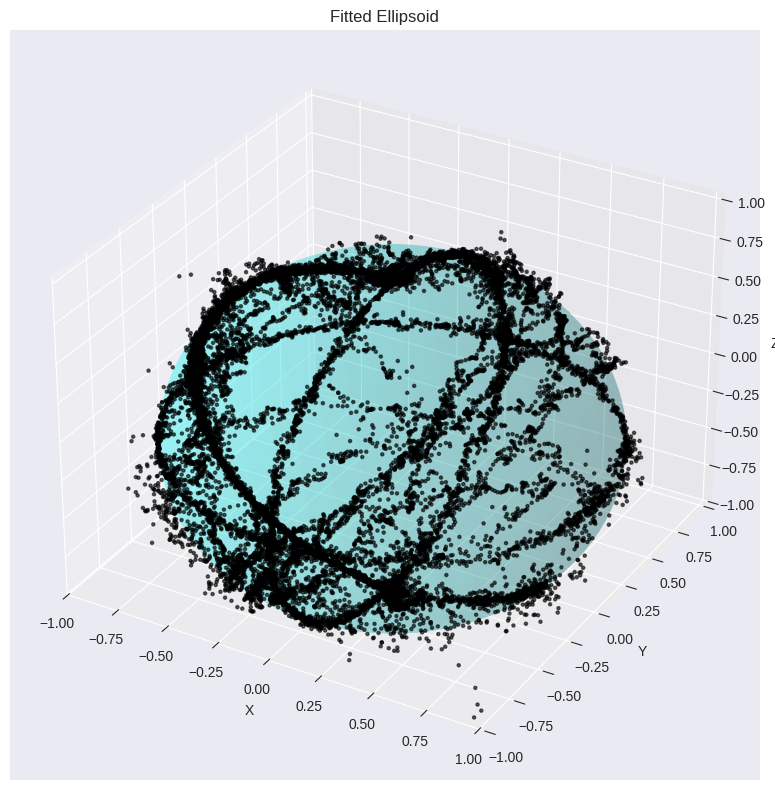

In [229]:
# Optional: pass in your raw data to overlay points
data = np.array([[d['ax'], d['ay'], d['az']] for d in samples])

plot_ellipsoid(center, radii, rotation, raw_data=data)

In [230]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_ellipsoid_with_projections(center, radii, rotation, raw_data):
    """
    Plots:
    - Fitted 3D ellipsoid surface
    - Raw 3D IMU data
    - 2D projections (XY, XZ, YZ) showing both raw data and ellipsoid projection
    """

    # Generate ellipsoid surface points
    u = np.linspace(0, 2 * np.pi, 60)
    v = np.linspace(0, np.pi, 60)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))

    # Scale, rotate, and translate sphere to form ellipsoid
    sphere = np.stack((x, y, z), axis=-1)
    ellipsoid = sphere @ np.diag(radii) @ rotation.T + center
    X, Y, Z = ellipsoid[:, :, 0], ellipsoid[:, :, 1], ellipsoid[:, :, 2]

    # Flatten ellipsoid surface points for projection plotting
    ellipsoid_points = np.column_stack((X.ravel(), Y.ravel(), Z.ravel()))

    # Extract raw data
    ax_vals = raw_data[:, 0]
    ay_vals = raw_data[:, 1]
    az_vals = raw_data[:, 2]

    # Setup figure and subplots manually
    fig = plt.figure(figsize=(12, 10))

    # 3D plot in position 1
    ax3d = fig.add_subplot(2, 2, 1, projection='3d')
    ax3d.plot_surface(X, Y, Z, rstride=2, cstride=2, color='cyan', alpha=0.3, linewidth=0)
    ax3d.scatter(ax_vals, ay_vals, az_vals, c='black', s=5, alpha=0.6)
    ax3d.set_title('3D Ellipsoid Fit')
    ax3d.set_xlabel('ax')
    ax3d.set_ylabel('ay')
    ax3d.set_zlabel('az')

    max_radius = np.max(radii)
    for axis in [ax3d.set_xlim, ax3d.set_ylim, ax3d.set_zlim]:
        axis(center[0] - max_radius, center[0] + max_radius)

    # Create other 2D subplots manually
    axs = [ax3d]
    for i in range(2, 5):  # subplot positions 2, 3, 4
        axs.append(fig.add_subplot(2, 2, i))

    # Define projections: (index_x, index_y, title, color)
    projections = [
        (0, 1, 'XY', 'green'),
        (0, 2, 'XZ', 'purple'),
        (1, 2, 'YZ', 'orange'),
    ]

    # Common axis limits for projections
    val = np.max(np.abs(raw_data)) + 0.2
    axis_lim = [-val, val]

    for k, (i, j, title, color) in enumerate(projections):
        ax = axs[k + 1]
        ax.scatter(raw_data[:, i], raw_data[:, j], c='black', s=10, alpha=0.6, label='Raw')
        ax.scatter(ellipsoid_points[:, i], ellipsoid_points[:, j], c=color, s=1, alpha=0.5, label='Ellipsoid')
        ax.set_xlabel(['ax', 'ay', 'az'][i])
        ax.set_ylabel(['ax', 'ay', 'az'][j])
        ax.set_title(f'{title} Projection')
        ax.grid(True)
        ax.set_aspect('equal')
        ax.set_xlim(axis_lim)
        ax.set_ylim(axis_lim)
        ax.legend(loc='lower right', fontsize='small')

    plt.tight_layout()
    plt.show()


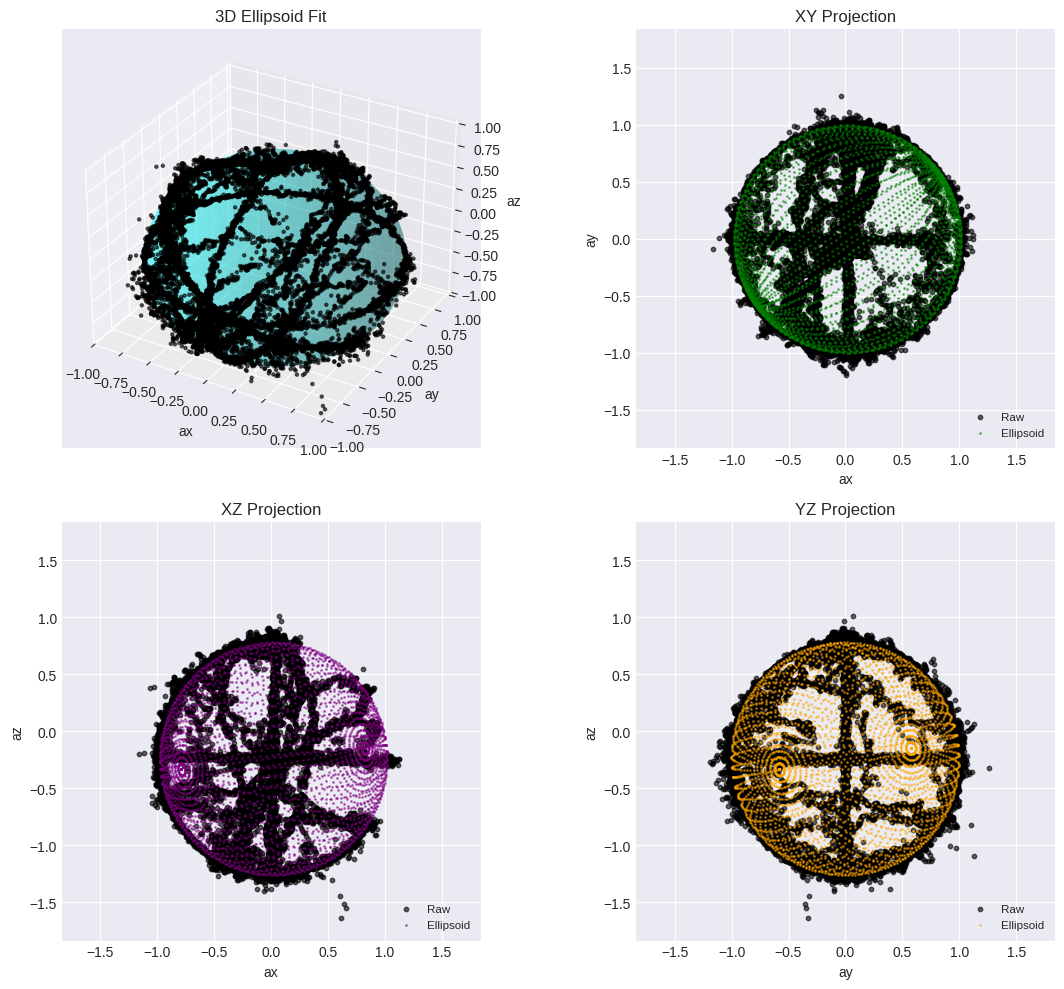

In [231]:
# Your IMU data
raw_data = np.array([[d['ax'], d['ay'], d['az']] for d in samples])

# Call the function
plot_ellipsoid_with_projections(center, radii, rotation, raw_data)

In [82]:
import numpy as np

bias = center
#radii
R = rotation

# Correction matrix (soft-iron)
M = R @ np.diag(1.0 / radii) @ R.T

def calibrate(raw):
    raw = np.asarray(raw)
    return (M @ (raw - bias).T).T


In [83]:
calibrate(data)

array([[ 1.47520954e-02,  7.45826932e-04,  1.00021560e+00],
       [ 1.63344764e-02,  1.84581049e-03,  9.98553179e-01],
       [ 1.47415474e-02,  3.19013891e-03,  9.97118394e-01],
       ...,
       [ 1.84017236e-02,  1.47881109e-03,  9.95819972e-01],
       [ 1.91252937e-02,  2.57859611e-03,  9.93082455e-01],
       [ 2.03471203e-02, -8.43983230e-04,  9.93205217e-01]],
      shape=(26796, 3))

# RANSAC Method

In [240]:
import numpy as np

def fit_ellipsoid_9point(points):
    """Minimal 9-point algebraic ellipsoid fit."""
    x, y, z = [points[:, i][:, None] for i in range(3)]
    D = np.hstack([x*x, y*y, z*z, x*y, x*z, y*z, x, y, z, np.ones_like(x)])
    _, _, vh = np.linalg.svd(D, full_matrices=False)
    v = vh.T[:, -1]
    return v  # raw coefficients

def algebraic_distance(v, pts):
    """Compute algebraic distance of points to ellipsoid defined by v."""
    x, y, z = pts[:, 0], pts[:, 1], pts[:, 2]
    A, B, C, D, E, F, G, H, I, J = v
    return (
        A*x*x + B*y*y + C*z*z + D*x*y + E*x*z + F*y*z + G*x + H*y + I*z + J
    )

def ransac_ellipsoid(data, n_iter=1000, thresh=0.002, min_inliers=0.6):
    best_v = None
    best_inliers = []
    N = data.shape[0]

    for _ in range(n_iter):
        # Random 9 unique points
        idx = np.random.choice(N, 9, replace=False)
        try:
            v = fit_ellipsoid_9point(data[idx])
        except np.linalg.LinAlgError:
            continue  # skip degenerate sample

        # Compute distances
        d = np.abs(algebraic_distance(v, data))
        inliers = np.where(d < thresh)[0]

        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_v = v

    # Refit with all inliers
    if len(best_inliers) / N < min_inliers:
        print("Warning: too few inliers, calibration might be poor.")
        print("Number of inliers: {}".format(len(best_inliers)))

    inlier_points = data[best_inliers]
    v_final = fit_ellipsoid_9point(inlier_points)

    return v_final, inlier_points


In [241]:
import numpy as np

# Suppose your list is called data_log
data = np.array([[d['ax'], d['ay'], d['az']] for d in samples])

In [242]:
v_best, inliers = ransac_ellipsoid(data, n_iter=20000, thresh=0.06, min_inliers=0.6)
center, radii, R = fit_ellipsoid_constrained(inliers)

print("Bias:", center)
print("Radii:", radii)
print("Rotation:\n", R)


Bias: [ 0.01922371 -0.00137135 -0.24049879]
Radii: [1.02268579 1.00214795 0.99498914]
Rotation:
 [[ 0.01238775  0.83121748 -0.55580936]
 [-0.22075542  0.54441001  0.80924952]
 [ 0.97525053  0.11267315  0.19023977]]


In [243]:
print(len(data))
print(len(inliers))

22917
21485


# Data Conditioning (see Horn's closed-form absolute orientation)

In [244]:
import numpy as np

def fit_ellipsoid_constrained(data):
    """
    Fits an ellipsoid to 3D points using an algebraic (constrained) fit,
    with Horn-style data conditioning (centering and scaling)
    for numerical stability.

    Returns:
        center:   (3,) ellipsoid center in original coordinates
        radii:    (3,) semi-axis lengths (a, b, c), sorted descending
        rotation: (3,3) rotation matrix (columns = principal axes)
    """
    data = np.asarray(data)

    # ----------------------------
    # 1. Data conditioning
    # ----------------------------
    mean = np.mean(data, axis=0)
    scale = np.std(data)
    if scale == 0:
        raise ValueError("Degenerate data: zero variance.")
    
    data_n = (data - mean) / scale  # normalized coordinates

    # ----------------------------
    # 2. Build design matrix
    # ----------------------------
    x = data_n[:, 0][:, None]
    y = data_n[:, 1][:, None]
    z = data_n[:, 2][:, None]

    # General quadric: Axx + Byy + Czz + Dxy + Exz + Fyz + Gx + Hy + Iz + J = 0
    D = np.hstack([x*x, y*y, z*z, x*y, x*z, y*z, x, y, z, np.ones_like(x)])

    # ----------------------------
    # 3. Solve algebraic system via SVD
    # ----------------------------
    _, _, vh = np.linalg.svd(D, full_matrices=False)
    v = vh.T[:, -1]

    # Unpack parameters
    Q = np.array([
        [v[0],   v[3]/2, v[4]/2],
        [v[3]/2, v[1],   v[5]/2],
        [v[4]/2, v[5]/2, v[2]]
    ])
    u = np.array([v[6], v[7], v[8]])
    f = v[9]

    if np.linalg.matrix_rank(Q) < 3:
        raise ValueError("Fitted quadric is degenerate (Q not full rank).")

    # ----------------------------
    # 4. Compute center in normalized space
    # ----------------------------
    center_n = -0.5 * np.linalg.solve(Q, u)
    k = center_n @ Q @ center_n - f

    eigvals = np.linalg.eigvalsh(Q)
    if k <= 0 or np.any(eigvals <= 0):
        Q, u, f = -Q, -u, -f
        center_n = -0.5 * np.linalg.solve(Q, u)
        k = center_n @ Q @ center_n - f
        eigvals = np.linalg.eigvalsh(Q)
    if k <= 0 or np.any(eigvals <= 0):
        raise ValueError("Fitted surface is not an ellipsoid (k<=0 or Q not PD).")

    # ----------------------------
    # 5. Diagonalize Q for axes and rotation
    # ----------------------------
    evals, evecs = np.linalg.eigh(Q)
    radii_n = np.sqrt(k / evals)

    # Sort axes largest→smallest
    order = np.argsort(radii_n)[::-1]
    radii_n = radii_n[order]
    rotation_n = evecs[:, order]

    # ----------------------------
    # 6. Transform results back to original coordinates
    # ----------------------------
    # Scaling and centering transformation: x = scale * x_n + mean
    # For the center:
    center = mean + scale * center_n

    # Radii scale with the same factor:
    radii = scale * radii_n
    rotation = rotation_n  # same rotation in both spaces (isotropic scaling)

    return center, radii, rotation


In [245]:
data = np.array([[d['ax'], d['ay'], d['az']] for d in samples])
center, radii, rotation = fit_ellipsoid_constrained(data)

print("Center:", center)
print("Radii:", radii)
print("Rotation matrix:\n", rotation)

Center: [ 0.01924962 -0.00300504 -0.24077741]
Radii: [1.0236168  1.00360566 0.99804111]
Rotation matrix:
 [[ 0.00250709 -0.63219219 -0.77480756]
 [-0.14966563  0.76584578 -0.62536425]
 [ 0.98873349  0.11752991 -0.09269739]]


In [247]:
#data = np.array([[d['ax'], d['ay'], d['az']] for d in data_log])
center, radii, rotation = fit_ellipsoid_constrained(inliers)

print("Center:", center)
print("Radii:", radii)
print("Rotation matrix:\n", rotation)

Center: [ 0.01944793 -0.001371   -0.24039459]
Radii: [1.02289934 1.00266772 0.99558525]
Rotation matrix:
 [[ 0.01852372  0.83985021 -0.54250206]
 [-0.22168701  0.53253955  0.8168577 ]
 [ 0.97494192  0.10513442  0.1960485 ]]


### Store Ellipsoid Data

In [248]:
import pickle

ellipsoid_data = {"center": center, "radii": radii, "rotation": rotation}

with open("ellipsoid_data.pkl", "wb") as f:
    pickle.dump(ellipsoid_data, f)

In [33]:
with open("ellipsoid_data.pkl", "rb") as f:
    ellipsoid_data = pickle.load(f)

In [249]:
ellipsoid_data

{'center': array([ 0.01944793, -0.001371  , -0.24039459]),
 'radii': array([1.02289934, 1.00266772, 0.99558525]),
 'rotation': array([[ 0.01852372,  0.83985021, -0.54250206],
        [-0.22168701,  0.53253955,  0.8168577 ],
        [ 0.97494192,  0.10513442,  0.1960485 ]])}

In [250]:
#plot_ellipsoid(center, radii, rotation, raw_data=inliers)

In [251]:
# Call the function
plot_ellipsoid_with_projections(center, radii, rotation, raw_data=inliers)
#plot_ellipsoid_with_projections(center, radii, rotation, raw_data=data)

# Re-order and flip axis to match expected rotation

Columns of R are the eigenvectors of Q.

Eigenvectors are only defined up to column permutation and sign flips.

In [93]:
# Suppose you got rotation (3x3) and radii (3,) from fit_ellipsoid_constrained()
# You want to match them so that:
#   a-axis ≈ X, b-axis ≈ Y, c-axis ≈ Z

import numpy as np
import itertools

def canonicalize_axes(rotation, radii):
    best_score = None
    best_R, best_r = None, None
    for perm in itertools.permutations(range(3)):
        Rp = rotation[:, perm]
        rp = radii[list(perm)]
        for signs in itertools.product([-1, 1], repeat=3):
            S = np.diag(signs)
            Rps = Rp @ S
            if np.linalg.det(Rps) < 0:  # keep right-handed
                continue
            # “Closeness to identity” criterion (align axes with X,Y,Z)
            score = np.trace(Rps)
            if best_score is None or score > best_score:
                best_score, best_R, best_r = score, Rps, rp
    return best_R, best_r

In [94]:
best_R, best_r = canonicalize_axes(rotation, radii)
print("Best R:\n", best_R)
print("Best r:\n", best_r)

Best R:
 [[ 0.99753533 -0.07013412  0.00211453]
 [ 0.07005947  0.99390863 -0.0850724 ]
 [ 0.00386483  0.08501087  0.99637253]]
Best r:
 [1.00023835 0.99806077 1.02241891]


In [95]:
import numpy as np

def rotation_to_rpy(R):
    """
    Convert a 3x3 rotation matrix to roll, pitch, yaw angles (in radians).

    Convention:
        R = Rz(yaw) * Ry(pitch) * Rx(roll)
        Intrinsic rotations about X (roll), Y (pitch), Z (yaw)
    Returns:
        roll, pitch, yaw
    """
    # Ensure R is a numpy array
    R = np.asarray(R)
    if R.shape != (3, 3):
        raise ValueError("Input must be a 3x3 rotation matrix")

    # Clamp for numerical safety
    sy = -R[2, 0]
    sy = np.clip(sy, -1.0, 1.0)

    pitch = np.arcsin(sy)
    if abs(sy) < 0.999999:
        roll = np.arctan2(R[2, 1], R[2, 2])
        yaw  = np.arctan2(R[1, 0], R[0, 0])
    else:
        # Gimbal lock case
        roll = 0.0
        yaw  = np.arctan2(-R[0, 1], R[1, 1])

    return roll, pitch, yaw


In [97]:
roll, pitch, yaw = rotation_to_rpy(best_R)
print("roll:", roll)
print("pitch:", pitch)
print("yaw:", yaw)
print("in deg:", np.degrees([roll,pitch,yaw]))

roll: 0.08511423355219935
pitch: -0.003864835570230497
yaw: 0.07011743009264952
in deg: [ 4.87668636 -0.22143877  4.01743281]


# Calibrate Offset and Scaling

In [252]:
import numpy as np

def calibrate_imu(m_raw, center, radii, rotation):
    """
    Apply ellipsoid calibration to 3D sensor measurements.

    Computes:
        m_cal = R.T @ diag(1/radii) @ R @ (m_raw - center)

    Args:
        m_raw:     (..., 3) array of raw 3D measurements
        center:    (3,) array, ellipsoid center (bias)
        radii:     (3,) array, semi-axis lengths from fit
        rotation:  (3,3) array, rotation matrix from fit (columns = principal axes)

    Returns:
        m_cal: (..., 3) array of calibrated measurements
    """
    m_raw = np.asarray(m_raw)
    center = np.asarray(center)
    radii = np.asarray(radii)
    rotation = np.asarray(rotation)

    # Ensure shapes
    if m_raw.shape[-1] != 3:
        raise ValueError("m_raw must have shape (..., 3)")
    if center.shape != (3,):
        raise ValueError("center must be shape (3,)")
    if radii.shape != (3,):
        raise ValueError("radii must be shape (3,)")
    if rotation.shape != (3, 3):
        raise ValueError("rotation must be shape (3,3)")

    # Bias correction (subtract center)
    m_centered = m_raw - center

    # Scale correction (soft-iron)
    scale = np.diag(1.0 / radii)

    # Full calibration
    m_cal = (rotation.T @ scale @ rotation @ m_centered.T).T  # keep same shape as input

    return m_cal


In [253]:
calibrated = [calibrate_imu(v, ellipsoid_data["center"], ellipsoid_data["radii"], ellipsoid_data["rotation"]) for v in inliers]

In [254]:
plot_ellipsoid_with_projections(center-center, radii, rotation, raw_data=np.array(calibrated))

# Calibrate Rotation

In [255]:
imu = MPU6050(
            url="ftdi://ftdi:232h/1",
            bus_rate=400_000,
            sample_div=4,     # 200 Hz
            dlpf_cfg=3,       # 42 Hz
            accel_cfg=0x00,   # ±2 g
            gyro_cfg=0x00,    # ±250 dps
            verbose=True
        )

🧩 Connected via ftdi://ftdi:232h/1 @ 400000 Hz, addr=0x68
🆔 WHO_AM_I = 0x68
FIFO count @ +50 ms: 300
FIFO count @ +100 ms: 624
FIFO count @ +200 ms: 1024

🔎 Register dump:
   WHO_AM_I      = 0x68
   PWR_MGMT_1    = 0x01
   PWR_MGMT_2    = 0x00
   CONFIG        = 0x03
   SMPLRT_DIV    = 0x04
   GYRO_CONFIG   = 0x00
   ACCEL_CONFIG  = 0x00
   USER_CTRL     = 0x40
   FIFO_EN       = 0x78
   INT_ENABLE    = 0x01
   INT_STATUS    = 0x11



In [256]:
samples = imu.capture(duration_s=300.0, max_samples=1e5, print_rate_hz=20.0)

📡 Capturing FIFO data... (Ctrl+C to stop)

A=(+0.02,-1.00,-0.24) g  G=(  -1.4,  +0.5,  +1.4) °/s  T=26.27°C  n_samples=10084     
🛑 Stopped by user.

📦 Recorded 10084 samples.


In [257]:
imu.close()

🔚 FIFO disabled, I²C connection closed.


In [258]:
samples[:1]

[{'t': 1762527181.59032,
  'ax': 0.0340576171875,
  'ay': 0.0018310546875,
  'az': 0.780029296875,
  'gx': -1.4961832061068703,
  'gy': 0.5343511450381679,
  'gz': 1.366412213740458,
  'temp': 25.906470588235294}]

In [259]:
data_a = np.array([[d['ax'], d['ay'], d['az']] for d in samples])

In [260]:
data_w = np.array([[d['gx'], d['gy'], d['gz']] for d in samples])

In [261]:
data_a = np.array([calibrate_imu(v, ellipsoid_data["center"], ellipsoid_data["radii"], ellipsoid_data["rotation"]) for v in data_a])

In [262]:
data_a[:5]

array([[0.01625666, 0.01247577, 1.01211502],
       [0.01453489, 0.01124327, 1.00871125],
       [0.01306371, 0.01040225, 1.00870117],
       [0.01368425, 0.00936994, 1.0138981 ],
       [0.01171573, 0.00836742, 1.00940655]])

In [263]:
samples[:1]

[{'t': 1762527181.59032,
  'ax': 0.0340576171875,
  'ay': 0.0018310546875,
  'az': 0.780029296875,
  'gx': -1.4961832061068703,
  'gy': 0.5343511450381679,
  'gz': 1.366412213740458,
  'temp': 25.906470588235294}]

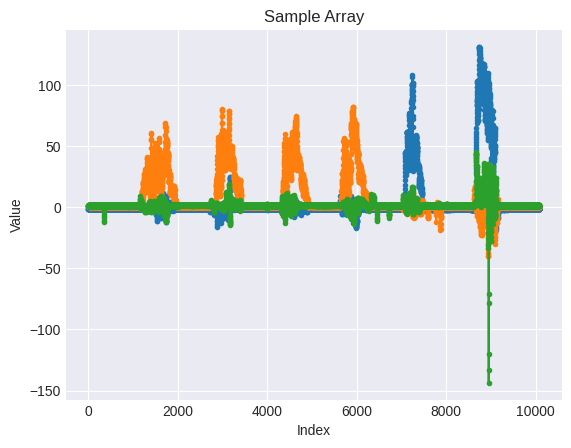

In [264]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sample(arr):
    """
    arr: numpy array of shape (1, n) or (n,)
    Produces a simple line plot of the values.
    """
    arr = np.squeeze(arr)  # flatten (1, n) to (n,)
    
    fig, ax = plt.subplots()
    ax.plot(arr, marker=".")
    ax.set_title("Sample Array")
    ax.set_xlabel("Index")
    ax.set_ylabel("Value")
    ax.grid(True)
    
    plt.show()

plot_sample(data_w)

In [265]:
vals = [np.linalg.norm(val) for val in data_w]

In [266]:
np.max(vals)

np.float64(174.02701552558685)

In [267]:
vals[0]

np.float64(2.0955137008139397)

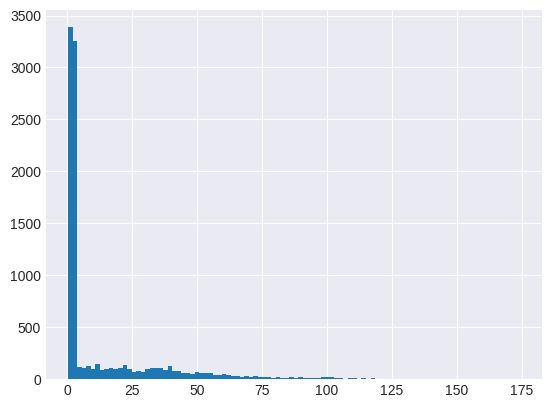

In [268]:
counts, bin_edges, patches = plt.hist(vals, bins=100)

In [269]:
bin_edges

array([  0.3629769 ,   2.09961728,   3.83625767,   5.57289806,
         7.30953844,   9.04617883,  10.78281922,  12.5194596 ,
        14.25609999,  15.99274037,  17.72938076,  19.46602115,
        21.20266153,  22.93930192,  24.67594231,  26.41258269,
        28.14922308,  29.88586347,  31.62250385,  33.35914424,
        35.09578462,  36.83242501,  38.5690654 ,  40.30570578,
        42.04234617,  43.77898656,  45.51562694,  47.25226733,
        48.98890771,  50.7255481 ,  52.46218849,  54.19882887,
        55.93546926,  57.67210965,  59.40875003,  61.14539042,
        62.8820308 ,  64.61867119,  66.35531158,  68.09195196,
        69.82859235,  71.56523274,  73.30187312,  75.03851351,
        76.77515389,  78.51179428,  80.24843467,  81.98507505,
        83.72171544,  85.45835583,  87.19499621,  88.9316366 ,
        90.66827698,  92.40491737,  94.14155776,  95.87819814,
        97.61483853,  99.35147892, 101.0881193 , 102.82475969,
       104.56140007, 106.29804046, 108.03468085, 109.77

### Filter Acceleration Values by Norm of Gyroscope Readings

In [270]:
limit_w = 2.6

In [271]:
data_a.shape

(10084, 3)

In [272]:
data_w.shape

(10084, 3)

In [273]:
# Filter by Gyro reading
data_a_filtered = []
data_w_filtered = []
for a, w in zip(data_a, data_w):
    if np.linalg.norm(w) < limit_w:
        data_a_filtered.append(a)
        data_w_filtered.append(w)
    


In [296]:
data_a_filtered[:10]

[array([0.01625666, 0.01247577, 1.01211502]),
 array([0.01453489, 0.01124327, 1.00871125]),
 array([0.01306371, 0.01040225, 1.00870117]),
 array([0.01368425, 0.00936994, 1.0138981 ]),
 array([0.01171573, 0.00836742, 1.00940655]),
 array([0.01587375, 0.00699725, 1.00383151]),
 array([0.0198125 , 0.00637778, 1.01460613]),
 array([0.01344286, 0.00795481, 1.01666895]),
 array([0.01649926, 0.00743126, 1.01182643]),
 array([0.01355454, 0.00860941, 1.0095327 ])]

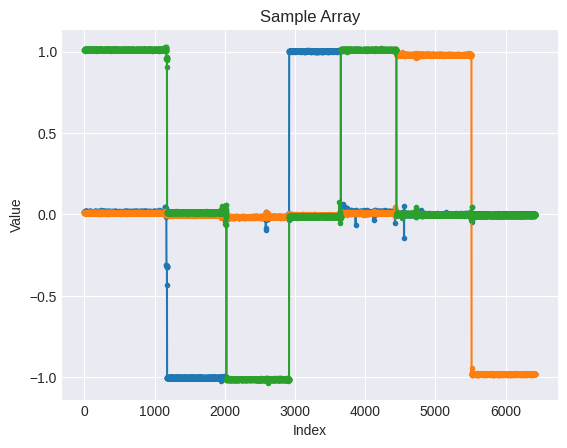

In [297]:
plot_sample(data_a_filtered)

In [298]:
for val in orientations:
    print(np.dot(data_a_filtered[0], val))

0.016256662570030146
-0.016256662570030146
0.01247577043332671
-0.01247577043332671
1.0121150224274476
-1.0121150224274476


In [409]:
orientations = [[ 1,  0,  0],
       [-1,  0,  0],
       [ 0,  1,  0],
       [ 0, -1,  0],
       [ 0,  0,  1],
       [ 0,  0, -1]]

In [299]:
orientations.shape

(6, 3)

In [412]:
# Sort Acceleration Vectors by Direction
data_samples = [[] for _ in range(6)]
for a in data_a_filtered:
    for idx, val in enumerate(orientations):
        if np.dot(a,val) > 0.9:
            data_samples[idx].append(a)
            continue

In [413]:
data_samples[0][:2]

[array([ 1.00560775, -0.00387886, -0.01212512]),
 array([ 1.00658159, -0.00140298, -0.01706406])]

In [414]:
plot_data = []
for idx in range(6):
    for val in data_samples[idx]:
        plot_data.append(val)

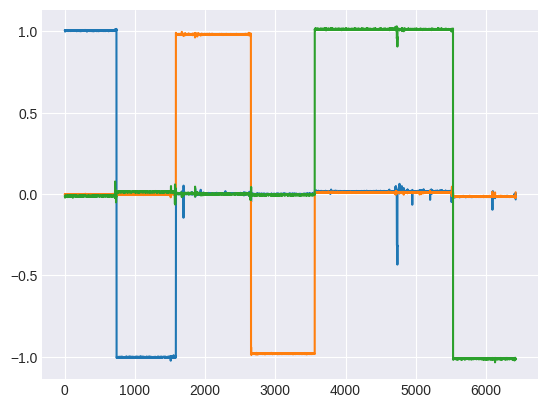

In [415]:
plt.plot(plot_data)

In [418]:
# Calculate Mean
for idx in range(len(data_samples)):
    data_samples[idx] = np.mean(np.array(data_samples[idx]), axis=0)

In [417]:
data_samples

[array([ 1.00342129, -0.00397206, -0.01275733]),
 array([-1.00291659, -0.00200902,  0.01231826]),
 array([1.03009742e-03, 9.80504558e-01, 4.20892429e-04]),
 array([-0.00127181, -0.98127135, -0.00594303]),
 array([0.01418466, 0.00902496, 1.0116439 ]),
 array([-0.01623368, -0.01509397, -1.01296691])]

In [285]:
import numpy as np

def estimate_rotation_from_six_poses(accel_rows):
    """
    accel_rows: iterable of 6 vectors, each a length-3 numpy array,
                measured gravity vectors in the SENSOR frame, one per major pose.
                Units can be g or m/s^2. Magnitude can vary slightly.
    Returns:
        R_ws: 3x3 rotation matrix that maps sensor-frame vectors -> world-frame vectors
              so that world_vec ≈ R_ws @ sensor_vec
    """
    A = np.vstack([np.asarray(v, dtype=float) for v in accel_rows])
    # 1) normalize
    A = A / np.linalg.norm(A, axis=1, keepdims=True)

    # 2) build corresponding world directions for each row by dominant axis + sign
    #    Gravity direction in world for these poses is one of the six cardinal axes.
    B = np.zeros_like(A)
    for i, v in enumerate(A):
        ax = np.argmax(np.abs(v))
        sgn = np.sign(v[ax]) if v[ax] != 0 else 1.0
        e = np.zeros(3)
        e[ax] = sgn
        B[i] = e

    # 3) Kabsch: find R minimizing sum ||R*a_i - b_i||^2
    # Build correlation H = B^T A
    H = B.T @ A
    U, S, Vt = np.linalg.svd(H)
    R = U @ np.diag([1, 1, np.linalg.det(U @ Vt)]) @ Vt
    return R

def rotation_matrix_to_euler_zyx(R):
    """
    Convert rotation matrix to ZYX Euler angles (yaw, pitch, roll) in radians.
    Returns yaw, pitch, roll with the convention:
      R = Rz(yaw) * Ry(pitch) * Rx(roll)
    """
    # guard for numerical drift
    r20 = R[2, 0]
    r20 = np.clip(r20, -1.0, 1.0)
    pitch = -np.arcsin(r20)
    yaw = np.arctan2(R[1,0], R[0,0])
    roll = np.arctan2(R[2,1], R[2,2])
    return yaw, pitch, roll

R_ws = estimate_rotation_from_six_poses(data_samples)
yaw, pitch, roll = rotation_matrix_to_euler_zyx(R_ws)

print("R_ws (sensor -> world):\n", R_ws)
print("Yaw, Pitch, Roll (rad):", yaw, pitch, roll)
print("Yaw, Pitch, Roll (deg):", np.degrees([yaw, pitch, roll]))


R_ws (sensor -> world):
 [[ 9.99904865e-01 -1.05581676e-03 -1.37530312e-02]
 [ 9.96214738e-04  9.99990087e-01 -4.33986734e-03]
 [ 1.37574770e-02  4.32575350e-03  9.99896004e-01]]
Yaw, Pitch, Roll (rad): 0.0009963091919920257 -0.013757910966713492 0.004326176412961979
Yaw, Pitch, Roll (deg): [ 0.05708431 -0.78827023  0.24787165]


### Store the Rotation Matrix

In [286]:
import pickle

rotation_data = {"rotation": R_ws}

with open("rotation_data.pkl", "wb") as f:
    pickle.dump(rotation_data, f)

In [ ]:
with open("rotation_data.pkl", "rb") as f:
    rotation_data = pickle.load(f)

# Apply Calibration to Captured Data

In [525]:
from pyftdi.i2c import I2cController
import struct, time, sys
from typing import List, Dict, Optional

class MPU6050:
    # --- I2C address ---
    DEFAULT_ADDR = 0x68

    # --- Registers ---
    REG_SMPLRT_DIV   = 0x19
    REG_CONFIG       = 0x1A
    REG_GYRO_CONFIG  = 0x1B
    REG_ACCEL_CONFIG = 0x1C
    REG_FIFO_EN      = 0x23
    REG_INT_ENABLE   = 0x38
    REG_INT_STATUS   = 0x3A
    REG_TEMP_OUT_H   = 0x41
    REG_TEMP_OUT_L   = 0x42
    REG_USER_CTRL    = 0x6A
    REG_PWR_MGMT_1   = 0x6B
    REG_PWR_MGMT_2   = 0x6C
    REG_FIFO_COUNTH  = 0x72
    REG_FIFO_COUNTL  = 0x73
    REG_FIFO_R_W     = 0x74
    REG_WHO_AM_I     = 0x75

    # --- Scales (±2 g, ±250 °/s) ---
    ACCEL_SCALE = 16384.0
    GYRO_SCALE  = 131.0

    def __init__(
        self,
        url: str = "ftdi://ftdi:232h/1",
        bus_rate: int = 400_000,
        addr: int = DEFAULT_ADDR,
        sample_div: int = 4,      # 1kHz/(1+div) => 200 Hz
        dlpf_cfg: int = 0x03,     # 42 Hz
        accel_cfg: int = 0x00,    # ±2 g
        gyro_cfg: int = 0x00,     # ±250 dps
        verbose: bool = True,
        check_id: bool = True,
        ellipsoid_data = None,
        rotation_data = None,
        gyro_offset = None,
        gyro_rotation = None
    ):
        self.verbose = verbose
        self.addr = addr

        # --- I2C setup ---
        self.i2c = I2cController()
        self.i2c.configure(f"{url}?frequency={bus_rate}")
        self.mpu = self.i2c.get_port(self.addr)

        if self.verbose:
            print(f"🧩 Connected via {url} @ {bus_rate} Hz, addr=0x{self.addr:02X}")

        # Optional identity check
        if check_id:
            who = self._read8(self.REG_WHO_AM_I)
            print(f"🆔 WHO_AM_I = 0x{who:02X}")
            if who != 0x68 and self.verbose:
                print("⚠️ Unexpected WHO_AM_I (check AD0/wiring)")

        self.is_calib_set = False
        self.ellipsoid_data = None
        self.rotation_data = None
        self.gyro_offset = None
        self.gyro_rotation = None
        if ellipsoid_data is not None:
            self.is_calib_set = True
            self.ellipsoid_data = ellipsoid_data
            print("Calibration ellipsoid data is available.")
        if rotation_data is not None:
            self.is_calib_set = True
            self.rotation_data = rotation_data
            print("Calibration rotation data is available.")
        if gyro_offset is not None:
            self.gyro_offset = gyro_offset
            print("Calibration gyro offset is available.")
        if gyro_rotation is not None:
            self.gyro_rotation = gyro_rotation
            print("Calibration gyro rotation is available.")
                
        # Init
        self._soft_init(sample_div, dlpf_cfg, accel_cfg, gyro_cfg)
        if self.verbose:
            self.dump_regs()

    # --------- Low-level I²C helpers ---------
    def _write8(self, reg: int, val: int) -> None:
        self.mpu.write_to(reg, bytes([val & 0xFF]))
        time.sleep(0.002)

    def _read8(self, reg: int) -> int:
        return self.mpu.exchange([reg], 1)[0]

    def _read16_be(self, reg: int) -> int:
        return struct.unpack('>H', self.mpu.exchange([reg], 2))[0]

    def _fifo_read(self, nbytes: int) -> bytes:
        return self.mpu.exchange([self.REG_FIFO_R_W], nbytes)

    def _fifo_reset(self) -> None:
        self._write8(self.REG_USER_CTRL, self._read8(self.REG_USER_CTRL) | 0x04)
        time.sleep(0.01)
        self._write8(self.REG_USER_CTRL, self._read8(self.REG_USER_CTRL) & ~0x04)
        time.sleep(0.01)

    # --------- Temperature ---------
    def read_temperature(self) -> float:
        """Read temperature once (°C) using datasheet formula."""
        h = self._read8(self.REG_TEMP_OUT_H)
        l = self._read8(self.REG_TEMP_OUT_L)
        raw = (h << 8) | l
        if raw >= 0x8000:
            raw -= 0x10000
        return raw / 340.0 + 36.53

    # --------- Init / control ---------
    def _soft_init(self, sample_div: int, dlpf_cfg: int, accel_cfg: int, gyro_cfg: int) -> None:
        # No hard reset (clones may NACK after 0x80)
        self._write8(self.REG_PWR_MGMT_1, 0x01)  # PLL X-gyro
        self._write8(self.REG_PWR_MGMT_2, 0x00)  # all sensors on
        time.sleep(0.05)

        # Basic config
        self._write8(self.REG_CONFIG, dlpf_cfg & 0x07)
        self._write8(self.REG_SMPLRT_DIV, sample_div & 0xFF)
        self._write8(self.REG_GYRO_CONFIG, gyro_cfg & 0x18)   # FS bits [4:3]
        self._write8(self.REG_ACCEL_CONFIG, accel_cfg & 0x18) # FS bits [4:3]

        # FIFO off, reset
        self._write8(self.REG_USER_CTRL, 0x00)
        self._write8(self.REG_FIFO_EN, 0x00)
        self._fifo_reset()
        time.sleep(0.05)

        # Enable FIFO logic + select accel+gyro
        self._write8(self.REG_USER_CTRL, 0x40)   # FIFO_EN (logic)
        self._write8(self.REG_FIFO_EN, 0x78)     # XG|YG|ZG|ACCEL
        self._write8(self.REG_INT_ENABLE, 0x01)  # data-ready (optional)
        _ = self._read8(self.REG_INT_STATUS)     # clear stale interrupt

        # Quick FIFO growth sanity
        if self.verbose:
            for t in (0.05, 0.10, 0.20):
                time.sleep(t)
                cnt = self._read16_be(self.REG_FIFO_COUNTH)
                print(f"FIFO count @ +{int(t*1000)} ms: {cnt}")

    def dump_regs(self) -> None:
        regs = [
            ("WHO_AM_I",     self.REG_WHO_AM_I),
            ("PWR_MGMT_1",   self.REG_PWR_MGMT_1),
            ("PWR_MGMT_2",   self.REG_PWR_MGMT_2),
            ("CONFIG",       self.REG_CONFIG),
            ("SMPLRT_DIV",   self.REG_SMPLRT_DIV),
            ("GYRO_CONFIG",  self.REG_GYRO_CONFIG),
            ("ACCEL_CONFIG", self.REG_ACCEL_CONFIG),
            ("USER_CTRL",    self.REG_USER_CTRL),
            ("FIFO_EN",      self.REG_FIFO_EN),
            ("INT_ENABLE",   self.REG_INT_ENABLE),
            ("INT_STATUS",   self.REG_INT_STATUS),
        ]
        print("\n🔎 Register dump:")
        for name, r in regs:
            print(f"   {name:<14}= 0x{self._read8(r):02X}")
        print()

    def calibrate_imu(self, m_raw, center, radii, rotation):
        """
        Apply ellipsoid calibration to 3D sensor measurements.
    
        Computes:
            m_cal = R.T @ diag(1/radii) @ R @ (m_raw - center)
    
        Args:
            m_raw:     (..., 3) array of raw 3D measurements
            center:    (3,) array, ellipsoid center (bias)
            radii:     (3,) array, semi-axis lengths from fit
            rotation:  (3,3) array, rotation matrix from fit (columns = principal axes)
    
        Returns:
            m_cal: (..., 3) array of calibrated measurements
        """
        m_raw = np.asarray(m_raw)
        center = np.asarray(center)
        radii = np.asarray(radii)
        rotation = np.asarray(rotation)
    
        # Ensure shapes
        if m_raw.shape[-1] != 3:
            raise ValueError("m_raw must have shape (..., 3)")
        if center.shape != (3,):
            raise ValueError("center must be shape (3,)")
        if radii.shape != (3,):
            raise ValueError("radii must be shape (3,)")
        if rotation.shape != (3, 3):
            raise ValueError("rotation must be shape (3,3)")
    
        # Bias correction (subtract center)
        m_centered = m_raw - center
    
        # Scale correction (soft-iron)
        scale = np.diag(1.0 / radii)
    
        # Full calibration
        m_cal = (rotation.T @ scale @ rotation @ m_centered.T).T  # keep same shape as input
    
        return m_cal

    # --------- Capture API ---------
    def capture(
        self,
        duration_s: Optional[float] = 5.0,
        max_samples: Optional[int] = None,
        print_rate_hz: float = 10.0,
        return_raw: bool = False,
        include_temp: bool = True,
    ) -> List[Dict[str, float]]:
        """
        Capture accel/gyro samples via FIFO, with optional temperature per batch.

        duration_s: stop after this many seconds (None to ignore)
        max_samples: stop after this many samples (None to ignore)
        print_rate_hz: terminal update rate (0 disables prints)
        return_raw: return raw ints instead of scaled floats
        include_temp: read temperature once per FIFO drain and add to each record

        Returns list of dicts: {t, ax, ay, az, gx, gy, gz, temp?}
        """
        if duration_s is None and max_samples is None:
            duration_s = 5.0

        data_log: List[Dict[str, float]] = []
        if self.verbose:
            print("📡 Capturing FIFO data... (Ctrl+C to stop)\n")

        t0 = time.time()
        last_print = 0.0
        bytes_per_sample = 12  # 6 accel + 6 gyro

        try:
            while True:
                if duration_s is not None and (time.time() - t0) >= duration_s:
                    break
                if max_samples is not None and len(data_log) >= max_samples:
                    break

                fifo_count = self._read16_be(self.REG_FIFO_COUNTH)

                if fifo_count > 1020:
                    self._fifo_reset()
                    continue

                if fifo_count < bytes_per_sample:
                    time.sleep(0.003)
                    continue

                # Read temperature once per batch if requested
                temp_c = self.read_temperature() if include_temp else None

                to_read = (fifo_count // bytes_per_sample) * bytes_per_sample
                blob = self._fifo_read(to_read)

                for i in range(0, len(blob), bytes_per_sample):
                    ax, ay, az, gx, gy, gz = struct.unpack('>hhhhhh', blob[i:i+bytes_per_sample])

                    rec_t = time.time()
                    if return_raw:
                        rec = {'t': rec_t, 'a': [ax, ay, az], 'g': [gx, gy, gz]}
                    else:
                        rec = {
                            't': rec_t,
                            'a': [ax/self.ACCEL_SCALE, ay/self.ACCEL_SCALE, az/self.ACCEL_SCALE],
                            'w': [gx/self.GYRO_SCALE, gy/self.GYRO_SCALE, gz/self.GYRO_SCALE]
                        }
                        if self.is_calib_set:
                            m_cal = rec["a"]
                            if self.calibrate_imu is not None:
                                m_cal = self.calibrate_imu(m_cal, ellipsoid_data["center"], ellipsoid_data["radii"], ellipsoid_data["rotation"])
                            if self.rotation_data is not None:
                                m_cal = self.rotation_data["rotation"] @ m_cal
                            rec["a"] = m_cal
                        if self.gyro_offset is not None:
                            dg = self.gyro_offset
                            rec['w'] = [rec['w'][0]-dg[0], rec['w'][1]-dg[1], rec['w'][2]-dg[2]]
                        if self.gyro_rotation is not None:
                            rec['w'] = gyro_rotation["rotation"] @ np.array(rec['w'])
                                        
                    if include_temp:
                        rec['temp'] = temp_c
                    data_log.append(rec)

                # Throttled console status
                if print_rate_hz and print_rate_hz > 0:
                    now = time.time()
                    if (now - last_print) >= (1.0 / print_rate_hz):
                        last_print = now
                        rec = data_log[-1]
                        if return_raw:
                            sys.stdout.write(
                                f"\rA=({rec['a'][0]:+6d},{rec['a'][1]:+6d},{rec['a'][2]:+6d})  "
                                f"G=({rec['w'][0]:+6d},{rec['w'][1]:+6d},{rec['w'][2]:+6d})  "
                                + (f"T={rec['temp']:.2f}°C  " if include_temp else "")
                                + f"n_samples={len(data_log)}     "
                            )
                        else:
                            sys.stdout.write(
                                f"\rA=({rec['a'][0]:+.2f},{rec['a'][1]:+.2f},{rec['a'][2]:+.2f}) g  "
                                f"G=({rec['w'][0]:+6.1f},{rec['w'][1]:+6.1f},{rec['w'][2]:+6.1f}) °/s  "
                                + (f"T={rec['temp']:.2f}°C  " if include_temp else "")
                                + f"n_samples={len(data_log)}     "
                            )
                        sys.stdout.flush()

        except Exception as e:
            import traceback
            traceback.print_exc()
            raise
        except KeyboardInterrupt:
            print("\n🛑 Stopped by user.")
        finally:
            if self.verbose:
                print(f"\n📦 Recorded {len(data_log)} samples.")
            return data_log

    # --------- Cleanup / context manager ---------
    def close(self) -> None:
        try:
            self._write8(self.REG_FIFO_EN, 0x00)
            self._write8(self.REG_USER_CTRL, self._read8(self.REG_USER_CTRL) & ~0x40)
        except Exception:
            pass
        self.i2c.terminate()
        if self.verbose:
            print("🔚 FIFO disabled, I²C connection closed.")

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc, tb):
        self.close()




In [517]:
imu = MPU6050(
            url="ftdi://ftdi:232h/1",
            bus_rate=400_000,
            sample_div=4,     # 200 Hz
            dlpf_cfg=3,       # 42 Hz
            accel_cfg=0x00,   # ±2 g
            gyro_cfg=0x00,    # ±250 dps
            verbose=True,
            ellipsoid_data=ellipsoid_data,
            rotation_data=rotation_data
        )

🧩 Connected via ftdi://ftdi:232h/1 @ 400000 Hz, addr=0x68
🆔 WHO_AM_I = 0x68
Calibration ellipsoid data is available.
Calibration rotation data is available.
FIFO count @ +50 ms: 300
FIFO count @ +100 ms: 636
FIFO count @ +200 ms: 1024

🔎 Register dump:
   WHO_AM_I      = 0x68
   PWR_MGMT_1    = 0x01
   PWR_MGMT_2    = 0x00
   CONFIG        = 0x03
   SMPLRT_DIV    = 0x04
   GYRO_CONFIG   = 0x00
   ACCEL_CONFIG  = 0x00
   USER_CTRL     = 0x40
   FIFO_EN       = 0x78
   INT_ENABLE    = 0x01
   INT_STATUS    = 0x11



In [518]:
samples = imu.capture(duration_s=300.0, max_samples=1e5, print_rate_hz=20.0)

📡 Capturing FIFO data... (Ctrl+C to stop)


📦 Recorded 0 samples.


Traceback (most recent call last):
  File "/tmp/ipykernel_3512294/1097116498.py", line 288, in capture
    if self.gyro_rotation is not None:
AttributeError: 'MPU6050' object has no attribute 'gyro_rotation'


In [376]:
imu.close()

🔚 FIFO disabled, I²C connection closed.


📊 Recorded 37127 samples over 185.885 s
⚙️ Expected sample rate: 200.0 Hz → Δt = 5.00 ms
🧠 Inferred actual rate: 199.7 Hz → Δt = 5.01 ms


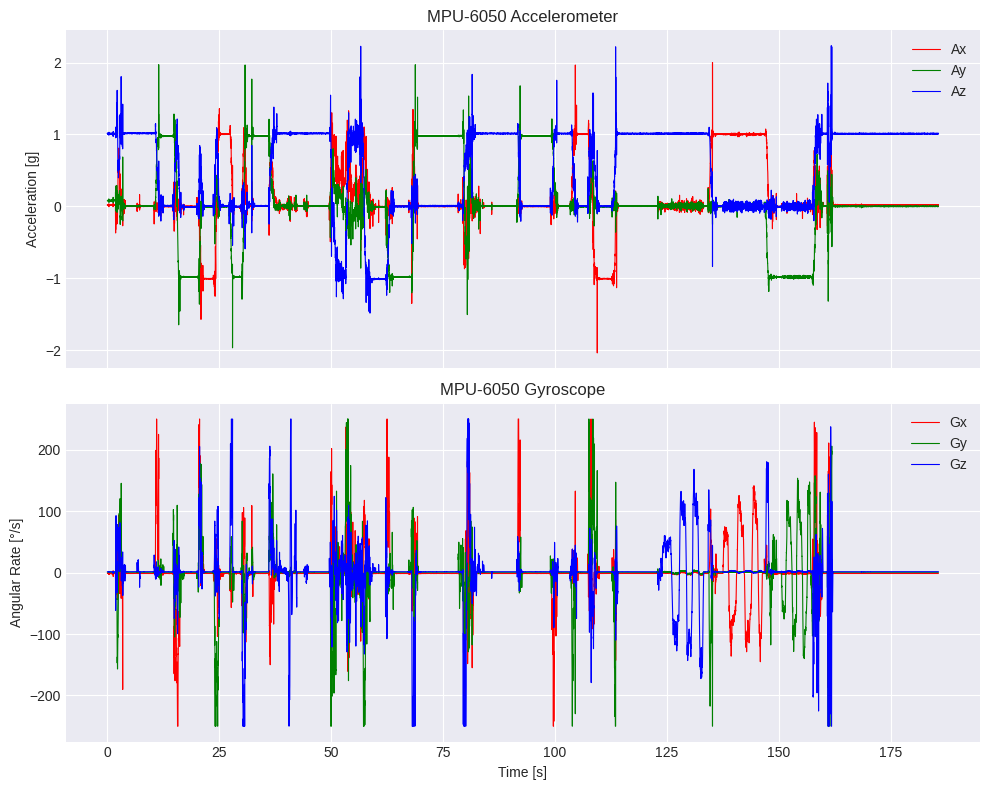

In [328]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mpu6050_dictlog(data_log, sample_rate_hz=200):
    """
    Plot MPU-6050 data when each sample is a dict:
    {'t': ..., 'ax': ..., 'ay': ..., 'az': ..., 'gx': ..., 'gy': ..., 'gz': ...}
    
    Arguments
    ----------
    data_log : list of dicts
        Recorded data points.
    sample_rate_hz : float
        Expected sample rate from the sensor configuration (Hz).
    """
    if not data_log:
        print("⚠️ data_log is empty — nothing to plot.")
        return

    n = len(data_log)

    # Extract recorded timestamps (real host-side times)
    host_t = np.array([d["t"] for d in data_log])
    total_time = host_t[-1] - host_t[0]
    actual_rate = (n - 1) / total_time if total_time > 0 else 0.0
    expected_rate = sample_rate_hz

    print(f"📊 Recorded {n} samples over {total_time:.3f} s")
    print(f"⚙️ Expected sample rate: {expected_rate:.1f} Hz → Δt = {1/expected_rate*1000:.2f} ms")
    print(f"🧠 Inferred actual rate: {actual_rate:.1f} Hz → Δt = {1/actual_rate*1000:.2f} ms")

    # Warn if difference >10%
    if abs(actual_rate - expected_rate) / expected_rate > 0.1:
        print("⚠️ WARNING: inferred rate differs from expected by >10% (host read delay or mis-set SMPLRT_DIV)")

    # Use synthetic uniform time base (true sample spacing)
    dt = 1.0 / expected_rate
    t = np.arange(n) * dt

    # Extract arrays
    ax = np.array([d["a"][0] for d in data_log])
    ay = np.array([d["a"][1] for d in data_log])
    az = np.array([d["a"][2] for d in data_log])
    gx = np.array([d["w"][0] for d in data_log])
    gy = np.array([d["w"][1] for d in data_log])
    gz = np.array([d["w"][2] for d in data_log])

    plt.style.use("seaborn-v0_8-darkgrid")
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # --- Accelerometer ---
    axs[0].plot(t, ax, "r-", lw=0.8, label="Ax")
    axs[0].plot(t, ay, "g-", lw=0.8, label="Ay")
    axs[0].plot(t, az, "b-", lw=0.8, label="Az")
    axs[0].set_ylabel("Acceleration [g]")
    axs[0].set_title("MPU-6050 Accelerometer")
    axs[0].legend(loc="upper right")

    # --- Gyroscope ---
    axs[1].plot(t, gx, "r-", lw=0.8, label="Gx")
    axs[1].plot(t, gy, "g-", lw=0.8, label="Gy")
    axs[1].plot(t, gz, "b-", lw=0.8, label="Gz")
    axs[1].set_ylabel("Angular Rate [°/s]")
    axs[1].set_xlabel("Time [s]")
    axs[1].set_title("MPU-6050 Gyroscope")
    axs[1].legend(loc="upper right")

    plt.tight_layout()
    plt.show()

plot_mpu6050_dictlog(samples)

In [295]:
samples[0]

{'t': 1762527386.5438087,
 'a': array([0.02244281, 0.01844027, 1.01031438]),
 'w': [-1.534351145038168, 0.6870229007633588, 1.3969465648854962],
 'temp': 25.84470588235294}

In [155]:
#plt.plot(data_samples)

In [154]:
data_samples[1][:5]

[array([-1.00520647, -0.00492785,  0.01564123]),
 array([-1.00104232, -0.00622863,  0.01330742]),
 array([-1.00203811, -0.00896389,  0.01513022]),
 array([-1.00362415, -0.00718259,  0.01575101]),
 array([-1.00153335, -0.00503026,  0.01599852])]

In [179]:
R_ws @ data_samples[5]

array([ 0.00209192, -0.00431052, -1.02310625])

# Calibrate Gyroscope

In [330]:
imu = MPU6050(
            url="ftdi://ftdi:232h/1",
            bus_rate=400_000,
            sample_div=4,     # 200 Hz
            dlpf_cfg=3,       # 42 Hz
            accel_cfg=0x00,   # ±2 g
            gyro_cfg=0x00,    # ±250 dps
            verbose=True,
            ellipsoid_data=ellipsoid_data,
            rotation_data=rotation_data
        )

🧩 Connected via ftdi://ftdi:232h/1 @ 400000 Hz, addr=0x68
🆔 WHO_AM_I = 0x68
Calibration ellipsoid data is available.
Calibration rotation data is available.
FIFO count @ +50 ms: 300
FIFO count @ +100 ms: 636
FIFO count @ +200 ms: 1024

🔎 Register dump:
   WHO_AM_I      = 0x68
   PWR_MGMT_1    = 0x01
   PWR_MGMT_2    = 0x00
   CONFIG        = 0x03
   SMPLRT_DIV    = 0x04
   GYRO_CONFIG   = 0x00
   ACCEL_CONFIG  = 0x00
   USER_CTRL     = 0x40
   FIFO_EN       = 0x78
   INT_ENABLE    = 0x01
   INT_STATUS    = 0x11



In [331]:
samples = imu.capture(duration_s=300.0, max_samples=1e5, print_rate_hz=20.0)

📡 Capturing FIFO data... (Ctrl+C to stop)

A=(+0.01,+0.02,+1.02) g  G=(  -1.5,  +0.6,  +1.4) °/s  T=25.70°C  n_samples=5211     
🛑 Stopped by user.

📦 Recorded 5211 samples.


In [332]:
imu.close()

🔚 FIFO disabled, I²C connection closed.


In [333]:
samples[0]

{'t': 1762529355.8748174,
 'a': array([0.00951423, 0.01832627, 1.01507941]),
 'w': [-1.5114503816793894, 0.6106870229007634, 1.4198473282442747],
 'temp': 25.644705882352945}

In [343]:
w_samples = [sample['w'] for sample in samples]

In [345]:
w_samples[:2]

[[-1.5114503816793894, 0.6106870229007634, 1.4198473282442747],
 [-1.4274809160305344, 0.5267175572519084, 1.381679389312977]]

In [346]:
w_offset = np.mean(np.array([sample['w'] for sample in samples]), axis=0)

In [555]:
w_offset

array([-1.44971222,  0.55114328,  1.39154988])

In [556]:
gyro_offset = {"offset": w_offset}

#with open("gyro_offset.pkl", "wb") as f:
#    pickle.dump(gyro_offset, f)

In [536]:
imu = MPU6050(
            url="ftdi://ftdi:232h/1",
            bus_rate=400_000,
            sample_div=4,     # 200 Hz
            dlpf_cfg=3,       # 42 Hz
            accel_cfg=0x00,   # ±2 g
            gyro_cfg=0x00,    # ±250 dps
            verbose=True,
            ellipsoid_data=ellipsoid_data,
            rotation_data=rotation_data,
            gyro_offset=w_offset
        )

🧩 Connected via ftdi://ftdi:232h/1 @ 400000 Hz, addr=0x68
🆔 WHO_AM_I = 0x68
Calibration ellipsoid data is available.
Calibration rotation data is available.
Calibration gyro offset is available.
FIFO count @ +50 ms: 312
FIFO count @ +100 ms: 636
FIFO count @ +200 ms: 1024

🔎 Register dump:
   WHO_AM_I      = 0x68
   PWR_MGMT_1    = 0x01
   PWR_MGMT_2    = 0x00
   CONFIG        = 0x03
   SMPLRT_DIV    = 0x04
   GYRO_CONFIG   = 0x00
   ACCEL_CONFIG  = 0x00
   USER_CTRL     = 0x40
   FIFO_EN       = 0x78
   INT_ENABLE    = 0x01
   INT_STATUS    = 0x11



In [537]:
samples = imu.capture(duration_s=300.0, max_samples=1e5, print_rate_hz=20.0)

📡 Capturing FIFO data... (Ctrl+C to stop)

A=(-0.00,-0.98,+0.00) g  G=(  +0.0,  -0.0,  +0.0) °/s  T=25.41°C  n_samples=13488     
🛑 Stopped by user.

📦 Recorded 13488 samples.


In [538]:
imu.close()

🔚 FIFO disabled, I²C connection closed.


📊 Recorded 13488 samples over 67.341 s
⚙️ Expected sample rate: 200.0 Hz → Δt = 5.00 ms
🧠 Inferred actual rate: 200.3 Hz → Δt = 4.99 ms


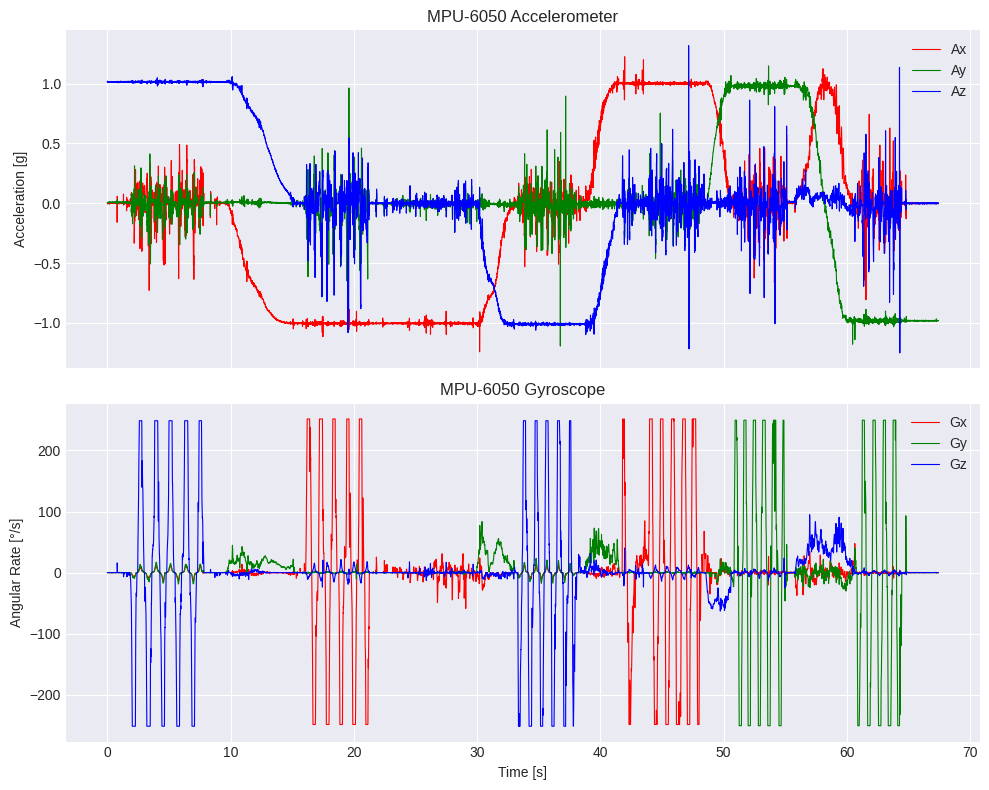

In [539]:
plot_mpu6050_dictlog(samples)

In [540]:
w_min = 150
w_max = 250

In [541]:
orientations = [[ 1,  0,  0],
       [-1,  0,  0],
       [ 0,  1,  0],
       [ 0, -1,  0],
       [ 0,  0,  1],
       [ 0,  0, -1]]

In [542]:
# Filter by Turn Rate Magnitude
data_samples = [[] for _ in range(6)]
w_data = [sample['w'] for sample in samples]
for w in w_data:
    wx = w[0]
    wy = w[1]
    wz = w[2]
    for idx, val in enumerate(orientations):
        if np.dot(w/np.linalg.norm(w), val) > 0.9:
            if np.abs(np.max(w)) > np.abs(np.min(w)):
                if np.max(w) < w_min or np.max(w) > w_max:
                    continue
            else:
                if np.min(w) > -w_min or np.min(w) < -w_max:
                    continue
            data_samples[idx].append(w)
            continue


In [544]:
data_samples[0][:2]

[[np.float64(163.39627710612166),
  np.float64(-1.5740440436481178),
  np.float64(-2.2083437707374673)],
 [np.float64(181.10620077024382),
  np.float64(-0.7114486238007895),
  np.float64(-2.7579620913481544)]]

In [545]:
plot_data = []
for idx in range(6):
    for val in data_samples[idx]:
        plot_data.append(val)

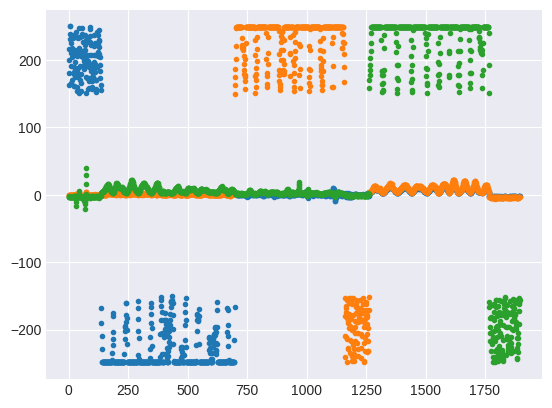

In [546]:
plt.plot(plot_data, '.')

In [547]:
# Calculate Mean
for idx in range(len(data_samples)):
    data_samples[idx] = np.mean(np.array(data_samples[idx]), axis=0)
    data_samples[idx] = data_samples[idx] / np.linalg.norm(data_samples[idx])

In [548]:
data_samples

[array([ 0.99989063, -0.00115277, -0.01474414]),
 array([-0.99950887,  0.00259788,  0.03122937]),
 array([0.00256409, 0.99993508, 0.01110193]),
 array([-0.00270761, -0.99998235, -0.0052881 ]),
 array([0.03126938, 0.04041645, 0.99869351]),
 array([-0.01563577, -0.02046214, -0.99966836])]

In [549]:
R_ws = estimate_rotation_from_six_poses(data_samples)
yaw, pitch, roll = rotation_matrix_to_euler_zyx(R_ws)

print("R_ws (sensor -> world):\n", R_ws)
print("Yaw, Pitch, Roll (rad):", yaw, pitch, roll)
print("Yaw, Pitch, Roll (deg):", np.degrees([yaw, pitch, roll]))

R_ws (sensor -> world):
 [[ 0.9997287  -0.00216143 -0.02319187]
 [ 0.00190339  0.99993611 -0.01114262]
 [ 0.02321447  0.01109546  0.99966893]]
Yaw, Pitch, Roll (rad): 0.001903901282963552 -0.02321655375678484 0.011098677202973166
Yaw, Pitch, Roll (deg): [ 0.10908551 -1.33021055  0.63590736]


In [550]:
gyro_rotation = {"rotation": R_ws}

#with open("gyro_rotation.pkl", "wb") as f:
#    pickle.dump(gyro_rotation, f)

In [497]:
R_ws @ samples[0]['w']

array([-0.02455886,  0.13552084,  0.04413238])

In [498]:
plot_data = []
for sample in samples:
    plot_data.append(R_ws @ sample['w'])

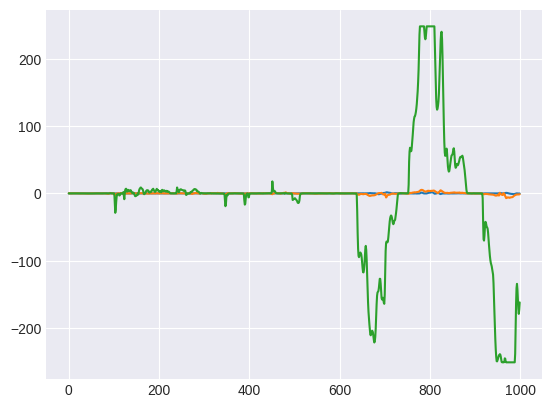

In [503]:
plt.plot(plot_data[:1000])

In [551]:
imu = MPU6050(
            url="ftdi://ftdi:232h/1",
            bus_rate=400_000,
            sample_div=4,     # 200 Hz
            dlpf_cfg=3,       # 42 Hz
            accel_cfg=0x00,   # ±2 g
            gyro_cfg=0x00,    # ±250 dps
            verbose=True,
            ellipsoid_data=ellipsoid_data,
            rotation_data=rotation_data,
            gyro_offset=w_offset,
            gyro_rotation=gyro_rotation
        )

🧩 Connected via ftdi://ftdi:232h/1 @ 400000 Hz, addr=0x68
🆔 WHO_AM_I = 0x68
Calibration ellipsoid data is available.
Calibration rotation data is available.
Calibration gyro offset is available.
Calibration gyro rotation is available.
FIFO count @ +50 ms: 300
FIFO count @ +100 ms: 636
FIFO count @ +200 ms: 1024

🔎 Register dump:
   WHO_AM_I      = 0x68
   PWR_MGMT_1    = 0x01
   PWR_MGMT_2    = 0x00
   CONFIG        = 0x03
   SMPLRT_DIV    = 0x04
   GYRO_CONFIG   = 0x00
   ACCEL_CONFIG  = 0x00
   USER_CTRL     = 0x40
   FIFO_EN       = 0x78
   INT_ENABLE    = 0x01
   INT_STATUS    = 0x11



In [552]:
samples = imu.capture(duration_s=300.0, max_samples=1e5, print_rate_hz=20.0)

📡 Capturing FIFO data... (Ctrl+C to stop)

A=(+0.00,+0.00,+1.01) g  G=(  +0.0,  -0.0,  -0.0) °/s  T=25.80°C  n_samples=21302     
🛑 Stopped by user.

📦 Recorded 21302 samples.


In [553]:
imu.close()

🔚 FIFO disabled, I²C connection closed.


📊 Recorded 21302 samples over 106.374 s
⚙️ Expected sample rate: 200.0 Hz → Δt = 5.00 ms
🧠 Inferred actual rate: 200.2 Hz → Δt = 4.99 ms


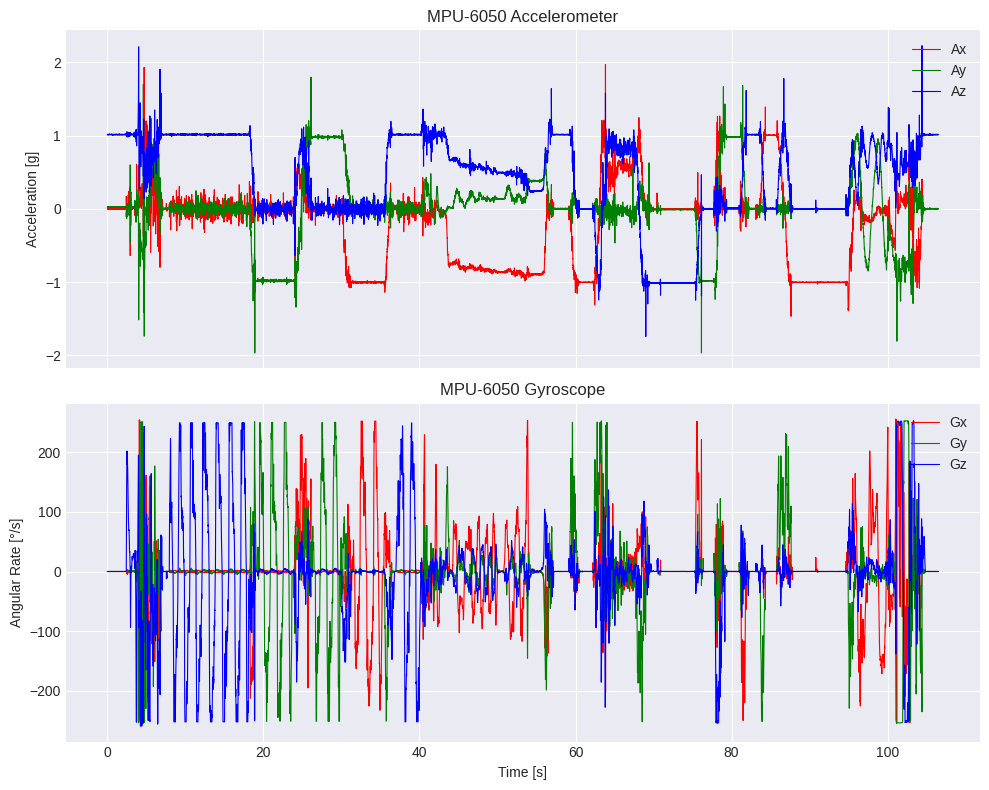

In [554]:
plot_mpu6050_dictlog(samples)

In [477]:
np.linalg.norm(data_samples, axis=0)

array([195.80732374, 200.91714619, 205.02676134])

In [420]:
samples[0]

{'t': 1762531160.090073,
 'a': array([0.00309607, 0.00604483, 1.00924422]),
 'w': [np.float64(-0.023570222122610174),
  np.float64(0.1358796204740197),
  np.float64(0.0435646262090974)],
 'temp': 25.353529411764708}

In [424]:
w_data[1]

[np.float64(-0.03883739769512928),
 np.float64(0.09007809375646236),
 np.float64(0.03593103842283796)]

In [407]:
np.mean(np.array([sample['w'] for sample in samples if sample['w'][2]>w_min and sample['w'][2]<w_max]), axis=0)

array([  2.59719314,   3.37678238, 156.1013011 ])

In [397]:
np.mean(np.array([sample['w'] for sample in samples if sample['w'][2]<-w_min]), axis=0)

array([  -2.26869186,   -2.9735674 , -142.46011909])

In [398]:
np.mean(np.array([sample['w'] for sample in samples if sample['w'][0]>w_min]), axis=0)

array([146.908742  ,  -0.1979321 ,  -2.36846353])

In [399]:
np.mean(np.array([sample['w'] for sample in samples if sample['w'][0]<-w_min]), axis=0)

array([-139.58314134,    0.16144923,    2.33396728])

In [400]:
np.mean(np.array([sample['w'] for sample in samples if sample['w'][1]>w_min]), axis=0)

array([  0.44646362, 149.73113889,   0.98654741])

In [401]:
np.mean(np.array([sample['w'] for sample in samples if sample['w'][1]<-w_min]), axis=0)

array([  -0.43376298, -136.5897945 ,   -0.98877103])

In [ ]:
# Filter Gyro Readings by Magnitude
data_w_filtered = []
for a, w in zip(data_a, data_w):
    
    if np.linalg.norm(w) < limit_w:
        data_a_filtered.append(a)
        data_w_filtered.append(w)

In [410]:
orientations = [[ 1,  0,  0],
       [-1,  0,  0],
       [ 0,  1,  0],
       [ 0, -1,  0],
       [ 0,  0,  1],
       [ 0,  0, -1]]

In [ ]:
data_samples = [[] for _ in range(6)]
for w in samples:
    for idx, val in enumerate(orientations):
        if np.dot(a,val) > 0.9:
            data_samples[idx].append(a)
            continue

In [411]:
samples[0]

{'t': 1762531160.090073,
 'a': array([0.00309607, 0.00604483, 1.00924422]),
 'w': [np.float64(-0.023570222122610174),
  np.float64(0.1358796204740197),
  np.float64(0.0435646262090974)],
 'temp': 25.353529411764708}

In [172]:
data_samples[0].T

array([ 1.00278825e+00, -6.03368948e-04, -1.73835098e-02])

### Remove outliers

In [ ]:
plt.

In [60]:
plot_mpu6050_dictlog(samples)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [39]:
idx = 0
m_raw = np.array([samples[idx]['ax'], samples[idx]['ay'], samples[idx]['az']])
m_cal = calibrate_imu(m_raw, ellipsoid_data["center"], ellipsoid_data["radii"], ellipsoid_data["rotation"])
print("m_raw:", m_raw)
print("m_cal:", m_cal)

m_raw: [0.03466797 0.00097656 0.78833008]
m_cal: [0.01347921 0.0048679  1.02632459]


In [40]:
np.linalg.norm(m_cal)

np.float64(1.0264246398588157)

In [41]:
idx = 0
m_raw = np.array([samples[idx]['ax'], samples[idx]['ay'], samples[idx]['az']])
m_cal = calibrate_imu(m_raw, center, best_r, best_R)
print("m_raw:", m_raw)
print("Calibrated vector:", m_cal)

NameError: name 'best_r' is not defined

In [42]:
plot_ellipsoid_with_projections(center, radii, rotation, raw_data=inliers[:15000])

In [101]:
calibrated = [calibrate_imu(v, center, best_r, best_R) for v in inliers]

In [102]:
plot_ellipsoid_with_projections(center-center, radii, rotation, raw_data=np.array(calibrated))

In [103]:
calibrated[0]

array([ 0.01101123, -0.00196471,  1.00203595])

In [104]:
np.linalg.norm(calibrated[100])

np.float64(0.9966279888764449)

In [105]:
samples[0]

{'t': 1762275266.2516515,
 'ax': 0.0318603515625,
 'ay': -0.00146484375,
 'az': 0.780029296875,
 'gx': -1.5954198473282444,
 'gy': 0.4732824427480916,
 'gz': 1.4045801526717556,
 'temp': 23.74764705882353}

In [106]:
inliers

array([[ 3.18603516e-02, -1.46484375e-03,  7.80029297e-01],
       [ 3.34472656e-02, -3.66210938e-04,  7.78320312e-01],
       [ 3.18603516e-02,  9.76562500e-04,  7.76855469e-01],
       ...,
       [ 3.55224609e-02, -7.32421875e-04,  7.75512695e-01],
       [ 3.62548828e-02,  3.66210938e-04,  7.72705078e-01],
       [ 3.74755859e-02, -3.05175781e-03,  7.72827148e-01]],
      shape=(25379, 3))

In [107]:
calibrated = [calibrate_imu(v, center, best_r, best_R) for v in inliers]

In [108]:
calibrated[:5]

[array([ 0.01101123, -0.00196471,  1.00203595]),
 array([ 1.25981064e-02, -8.60457667e-04,  1.00036176e+00]),
 array([1.10118898e-02, 4.87410263e-04, 9.98926226e-01]),
 array([ 9.30252321e-03, -3.82405457e-04,  1.00549593e+00]),
 array([ 0.01174359, -0.0029377 ,  0.99953014])]